# A) EDA Profesional: Home Credit Default Risk

Objetivo: EDA completo con verificación de integridad, nulos, relaciones entre tablas y primeros insights para features.

## 0) Rutas

In [ ]:
# --- Bootstrap / Smoke test ---
import sys, importlib, subprocess, os, warnings
warnings.filterwarnings("ignore")

def _ensure(pkg_import, pip_name=None):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        return True
    except Exception:
        print(f"[setup] Instalando {pip_name} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        importlib.invalidate_caches()
        importlib.import_module(pkg_import)
        return True

# Dependencias mínimas
for imp, pipn in [
    ("numpy","numpy"), ("pandas","pandas"), ("sklearn","scikit-learn"),
    ("lightgbm","lightgbm"), ("xgboost","xgboost"), ("catboost","catboost")
]:
    _ensure(imp, pipn)

import numpy as np, pandas as pd

# --- Rutas y parámetros globales (ajustar si se usa otra estructura) ---
DATA_PATH = "../../data/raw/home-credit-default-risk/"   # <--- ajusta si es necesario
OUTPUT_DIR = "./"                                        # donde guardar OOF/submissions
SEED = 42
N_FOLDS = 5

# Validaciones rápidas de archivos
req = ["application_train.csv", "application_test.csv"]
missing = [f for f in req if not os.path.exists(os.path.join(DATA_PATH, f))]
if missing:
    raise FileNotFoundError(f"No encuentro {missing} en DATA_PATH={DATA_PATH}")

# Sanity check de columnas clave
train_head = pd.read_csv(os.path.join(DATA_PATH, "application_train.csv"), nrows=500)
need = {"SK_ID_CURR","TARGET"}
if not need.issubset(set(train_head.columns)):
    raise AssertionError(f"Faltan columnas {need - set(train_head.columns)} en application_train.csv")

print("[OK] Entorno listo. DATA_PATH verificado, dependencias importadas.")
print(f"[INFO] SEED={SEED}, N_FOLDS={N_FOLDS}, OUTPUT_DIR={os.path.abspath(OUTPUT_DIR)}")


In [96]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Ruta base del proyecto (directorio actual del proyecto)
PROJ = Path.cwd()

# Ruta correcta a la carpeta de datos
DATA_RAW = PROJ.parent.parent / "data" / "raw" / "home-credit-default-risk"


print("PROJ:", PROJ)
print("DATA_RAW:", DATA_RAW)
print("DATA_RAW exists:", DATA_RAW.exists())

# Función para ver el uso de memoria de un DataFrame
def mem(df):
    return f"{df.memory_usage(deep=True).sum()/1024/1024:.2f} MB"


PROJ: C:\Users\excee\ai-datos_two-mvps_weekplan\credit_risk_home_credit\notebooks
DATA_RAW: C:\Users\excee\ai-datos_two-mvps_weekplan\data\raw\home-credit-default-risk
DATA_RAW exists: True


## 1) Comprobación de ficheros

In [97]:

# 1) Comprobación de ficheros esperados
expected = [
    "application_train.csv",
    "application_test.csv",
    "bureau.csv",
    "bureau_balance.csv",
    "credit_card_balance.csv",
    "HomeCredit_columns_description.csv",
    "installments_payments.csv",
    "POS_CASH_balance.csv",
    "previous_application.csv",
    "sample_submission.csv"
]

missing = [f for f in expected if not (DATA_RAW / f).exists()]

if missing:
    print("❌ Archivos faltantes:", missing)
else:
    print("✅ Todos los archivos están presentes.")



✅ Todos los archivos están presentes.


In [98]:
# ——— Celda: Recuperar train/test y renombrar columnas (robusto ES/EN) ———
import pandas as pd
from pathlib import Path

def pick_df(*names):
    """Devuelve el primer DataFrame que exista en globals() con cualquiera de estos nombres."""
    for n in names:
        if n in globals():
            obj = globals()[n]
            # es un DataFrame?
            if hasattr(obj, "head"):
                return obj
    return None

# 1) Intentamos recuperar DATA_RAW si no existe
if "DATA_RAW" not in globals():
    PROJ = Path.cwd()
    posibles = [
        PROJ / "data" / "raw" / "home-credit-default-risk",
        PROJ.parent / "data" / "raw" / "home-credit-default-risk",
        PROJ / "home-credit-default-risk",
    ]
    DATA_RAW = next((p for p in posibles if p.exists()), None)

# 2) Recuperar/leer app_train y app_test
app_train = pick_df("app_train", "application_train", "train_df")
app_test  = pick_df("app_test", "application_test", "test_df")

if app_train is None and DATA_RAW is not None:
    app_train = pd.read_csv(DATA_RAW / "application_train.csv")
if app_test is None and DATA_RAW is not None:
    app_test = pd.read_csv(DATA_RAW / "application_test.csv")

if app_train is None:
    raise RuntimeError(
        "No encuentro app_train ni puedo leer application_train.csv. "
        "Vuelve a ejecutar la celda de Rutas/Carga (día 1) para definir DATA_RAW y leer los CSV."
    )

# 3) Traducciones (ajustar/añadir las que se estén usando)
traducciones = {
    "SK_ID_CURR": "ID_CLIENTE",
    "TARGET": "IMPAGO",
    "NAME_CONTRACT_TYPE": "TIPO_CONTRATO",
    "CODE_GENDER": "SEXO",
    "FLAG_OWN_CAR": "POSEE_COCHE",
    "FLAG_OWN_REALTY": "POSEE_VIVIENDA",
    "CNT_CHILDREN": "N_HIJOS",
    "AMT_INCOME_TOTAL": "INGRESO_TOTAL",
    "AMT_CREDIT": "CREDITO_SOLICITADO",
    "AMT_ANNUITY": "ANUALIDAD",
    "AMT_GOODS_PRICE": "PRECIO_BIEN",
    "DAYS_BIRTH": "DIAS_DESDE_NACIMIENTO",
    "DAYS_EMPLOYED": "DIAS_EMPLEADO",
    "DAYS_REGISTRATION": "DIAS_REGISTRO",
    "DAYS_ID_PUBLISH": "DIAS_ID_PUBLICACION",
    "OWN_CAR_AGE": "ANTIGUEDAD_COCHE",
    "FLAG_MOBIL": "TIENE_MOVIL",
    "FLAG_EMP_PHONE": "TIENE_TELEFONO_EMPRESA",
    "FLAG_WORK_PHONE": "TIENE_TELEFONO_TRABAJO",
    "FLAG_CONT_MOBILE": "TELEFONO_CONTACTO",
    "CREDIT_INCOME_RATIO": "RATIO_CREDITO_INGRESO",  # comprobar que no hay duplicados
}

# 4) Renombramos de forma segura
for name, df in (("app_train", app_train), ("app_test", app_test)):
    if df is not None:
        df.rename(columns=traducciones, inplace=True)
        globals()[name] = df  # reinyectamos con estos nombres

print("✅ Variables renombradas correctamente. Ejemplo en train:")
print(app_train.columns[:15])


✅ Variables renombradas correctamente. Ejemplo en train:
Index(['ID_CLIENTE', 'IMPAGO', 'TIPO_CONTRATO', 'SEXO', 'POSEE_COCHE',
       'POSEE_VIVIENDA', 'N_HIJOS', 'INGRESO_TOTAL', 'CREDITO_SOLICITADO',
       'ANUALIDAD', 'PRECIO_BIEN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'],
      dtype='object')


## 2) Carga inicial + chequeos básicos

## 3) Limpiezas mínimas

In [101]:
# Sanity check rápido
assert 'app_train' in globals() and isinstance(app_train, pd.DataFrame)
assert 'app_test'  in globals() and isinstance(app_test, pd.DataFrame)
print("OK: app_train/app_test cargados:", app_train.shape, app_test.shape)


OK: app_train/app_test cargados: (307511, 124) (48744, 123)


In [102]:

# 3) Limpiezas mínimas (robusta para columnas en ES o EN)

import numpy as np
import pandas as pd
from pathlib import Path

# Helper para elegir el nombre de columna disponible (ES o EN)
def pick(df, *candidatas):
    for c in candidatas:
        if c in df.columns:
            return c
    return None

# Detectamos nombres en ES o EN
id_col           = pick(app_train, "ID_CLIENTE", "SK_ID_CURR")
target_col       = pick(app_train, "IMPAGO", "TARGET")
income_col       = pick(app_train, "INGRESO_TOTAL", "AMT_INCOME_TOTAL")
credit_col       = pick(app_train, "CREDITO_SOLICITADO", "AMT_CREDIT")
days_birth_col   = pick(app_train, "DIAS_DESDE_NACIMIENTO", "DAYS_BIRTH")
days_employed_col= pick(app_train, "DIAS_EMPLEADO", "DAYS_EMPLOYED")

# Helpers
def mem(df): 
    return f"{df.memory_usage(deep=True).sum()/1024/1024:.2f} MB"

print("PROJ:", Path.cwd())

# 3.1) Integridad de clave
if id_col:
    print(f"🔑 {id_col} es única en train:", app_train[id_col].is_unique)
    if 'app_test' in globals() and app_test is not None and id_col in app_test.columns:
        print(f"🔑 {id_col} es única en test :", app_test[id_col].is_unique)

    dups_train = app_train.duplicated(subset=[id_col]).sum()
    dups_test  = app_test.duplicated(subset=[id_col]).sum() if 'app_test' in globals() and id_col in app_test.columns else 0
    print(f"📦 Duplicados en train: {dups_train} | en test: {dups_test}")
else:
    print("⚠️ No se encontró columna de ID (ID_CLIENTE/SK_ID_CURR).")

# 3.2) Features básicas si no existen

# EDAD_ANIOS a partir de DIAS_DESDE_NACIMIENTO / DAYS_BIRTH
if "EDAD_ANIOS" not in app_train.columns and days_birth_col:
    app_train["EDAD_ANIOS"] = (-app_train[days_birth_col] / 365.25).astype(float)
    if 'app_test' in globals() and days_birth_col in app_test.columns:
        app_test["EDAD_ANIOS"] = (-app_test[days_birth_col] / 365.25).astype(float)

# RATIO_CREDITO_INGRESO a partir de CREDITO_SOLICITADO/INGRESO_TOTAL o AMT_CREDIT/AMT_INCOME_TOTAL
ratio_col = "RATIO_CREDITO_INGRESO"
if ratio_col not in app_train.columns and credit_col and income_col:
    app_train[ratio_col] = app_train[credit_col] / app_train[income_col]
    if 'app_test' in globals() and credit_col in app_test.columns and income_col in app_test.columns:
        app_test[ratio_col] = app_test[credit_col] / app_test[income_col]

print("👉 Columnas añadidas si no existían:", [c for c in ["EDAD_ANIOS", ratio_col] if c in app_train.columns])

# 3.3) Nulos rápidos
top_nulls = (app_train.isna().mean().sort_values(ascending=False).head(15) * 100).to_frame("% nulos")
print("\nTop 15 % nulos en train:")
display(top_nulls)

# 3.4) Memoria
print("mem(train):", mem(app_train), "| mem(test):", mem(app_test) if 'app_test' in globals() else "N/A")


PROJ: C:\Users\excee\ai-datos_two-mvps_weekplan\credit_risk_home_credit\notebooks
🔑 ID_CLIENTE es única en train: True
🔑 ID_CLIENTE es única en test : True
📦 Duplicados en train: 0 | en test: 0
👉 Columnas añadidas si no existían: ['EDAD_ANIOS', 'RATIO_CREDITO_INGRESO']

Top 15 % nulos en train:


,% nulos
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
COMMONAREA_MEDI,69.872297
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MEDI,68.354953
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MODE,68.354953


mem(train): 541.38 MB | mem(test): 85.48 MB


## 4) Nulos

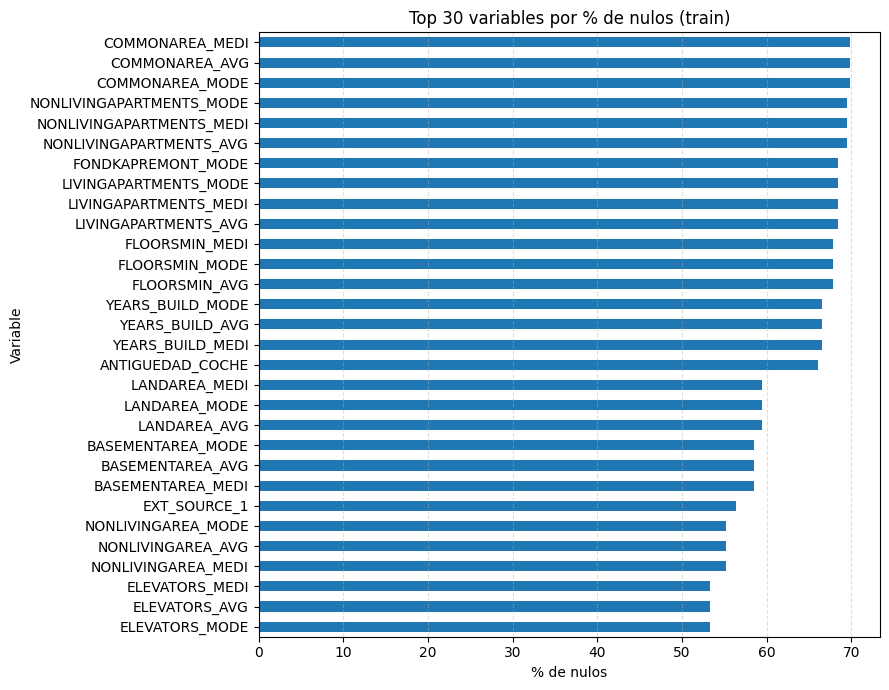

Candidatos a descartar (>=60% nulos): 17
A imputar (20–60%): 33 | A imputar simple (<20%): 17


In [103]:

# === 4) Nulos (visualización y decisiones) ===
import numpy as np
import matplotlib.pyplot as plt

nulls_pct = (app_train.isnull().mean()*100).sort_values(ascending=False)
top30 = nulls_pct.head(30)

plt.figure(figsize=(9,7))
(top30.sort_values()).plot(kind="barh")
plt.title("Top 30 variables por % de nulos (train)")
plt.xlabel("% de nulos")
plt.ylabel("Variable")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Reglas simples (ajusta umbrales)
ALTOS  = list(nulls_pct[nulls_pct >= 60].index)   # candidatos a descartar
MEDIOS = list(nulls_pct[(nulls_pct >= 20) & (nulls_pct < 60)].index)  # imputación con estrategia
BAJOS  = list(nulls_pct[(nulls_pct > 0) & (nulls_pct < 20)].index)    # imputación simple

print(f"Candidatos a descartar (>=60% nulos): {len(ALTOS)}")
print(f"A imputar (20–60%): {len(MEDIOS)} | A imputar simple (<20%): {len(BAJOS)}")


## 5) Gráficos básicos (matplotlib puro)

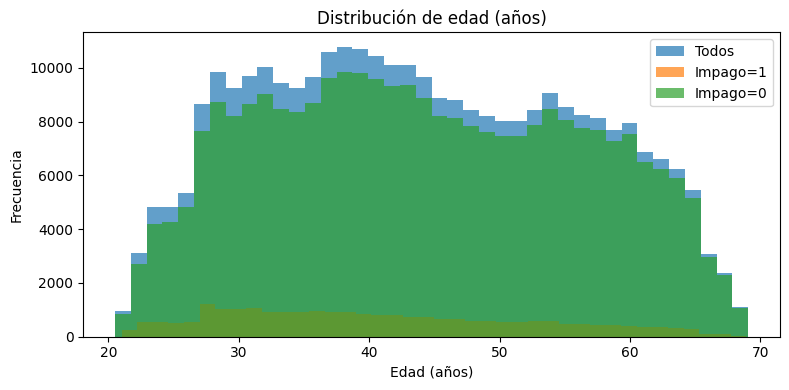

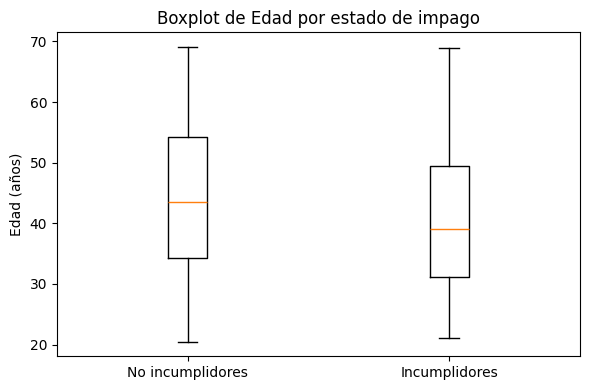

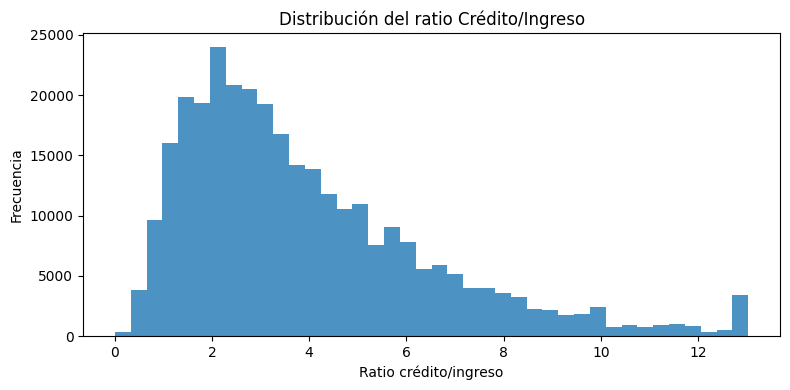

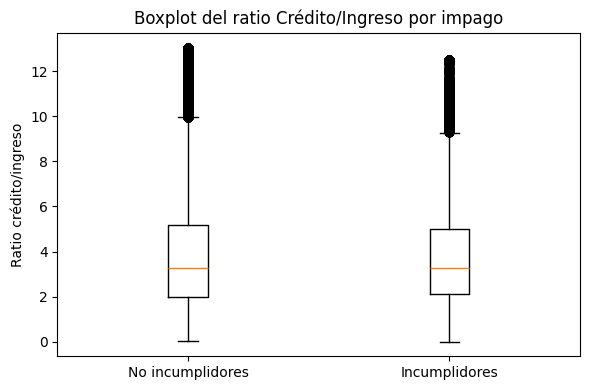

In [104]:
# === 5) Gráficos básicos (robusto a ES/EN; solo matplotlib) ===
import numpy as np
import matplotlib.pyplot as plt

def pick(df, *candidatas):
    for c in candidatas:
        if c in df.columns:
            return c
    return None

# Columnas clave (ES/EN)
id_col      = pick(app_train, "ID_CLIENTE", "SK_ID_CURR")
target_col  = pick(app_train, "IMPAGO", "TARGET")
ing_col     = pick(app_train, "INGRESO_TOTAL", "AMT_INCOME_TOTAL")
cred_col    = pick(app_train, "CREDITO_SOLICITADO", "AMT_CREDIT")
edad_col    = pick(app_train, "EDAD_ANIOS", None)
dias_birth  = pick(app_train, "DIAS_DESDE_NACIMIENTO", "DAYS_BIRTH")
ratio_col   = pick(app_train, "RATIO_CREDITO_INGRESO", None)

# Crear EDAD_ANIOS si no existe y tenemos días de nacimiento
if edad_col is None and dias_birth is not None:
    app_train["EDAD_ANIOS"] = (-app_train[dias_birth] / 365.25).astype(float)
    if 'app_test' in globals() and dias_birth in getattr(app_test, 'columns', []):
        app_test["EDAD_ANIOS"] = (-app_test[dias_birth] / 365.25).astype(float)
    edad_col = "EDAD_ANIOS"

# Crear RATIO_CREDITO_INGRESO si no existe y tenemos ingreso/crédito
if ratio_col is None and (cred_col is not None and ing_col is not None):
    app_train["RATIO_CREDITO_INGRESO"] = app_train[cred_col] / app_train[ing_col]
    if 'app_test' in globals() and cred_col in getattr(app_test, 'columns', []) and ing_col in app_test.columns:
        app_test["RATIO_CREDITO_INGRESO"] = app_test[cred_col] / app_test[ing_col]
    ratio_col = "RATIO_CREDITO_INGRESO"

# 5.1 Histograma de EDAD (general y por estado de impago)
if edad_col is not None:
    plt.figure(figsize=(8,4))
    plt.hist(app_train[edad_col].dropna(), bins=40, alpha=0.7, label="Todos")
    if target_col is not None:
        plt.hist(app_train.loc[app_train[target_col]==1, edad_col].dropna(),
                 bins=40, alpha=0.7, label="Impago=1")
        plt.hist(app_train.loc[app_train[target_col]==0, edad_col].dropna(),
                 bins=40, alpha=0.7, label="Impago=0")
    plt.title("Distribución de edad (años)")
    plt.xlabel("Edad (años)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplot de edad por impago
    if target_col is not None:
        data_bp = [app_train.loc[app_train[target_col]==0, edad_col].dropna(),
                   app_train.loc[app_train[target_col]==1, edad_col].dropna()]
        plt.figure(figsize=(6,4))
        plt.boxplot(data_bp, labels=["No incumplidores", "Incumplidores"])
        plt.title("Boxplot de Edad por estado de impago")
        plt.ylabel("Edad (años)")
        plt.tight_layout()
        plt.show()

# 5.2 Histograma y boxplot del RATIO_CREDITO_INGRESO
if ratio_col is not None:
    plt.figure(figsize=(8,4))
    plt.hist(app_train[ratio_col].dropna().clip(upper=np.nanpercentile(app_train[ratio_col], 99)),
             bins=40, alpha=0.8)
    plt.title("Distribución del ratio Crédito/Ingreso")
    plt.xlabel("Ratio crédito/ingreso")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    if target_col is not None:
        data_bp = [app_train.loc[app_train[target_col]==0, ratio_col].dropna(),
                   app_train.loc[app_train[target_col]==1, ratio_col].dropna()]
        # limitar outliers extremos para visualizar mejor
        data_bp = [d.clip(upper=np.nanpercentile(d, 99)) for d in data_bp]
        plt.figure(figsize=(6,4))
        plt.boxplot(data_bp, labels=["No incumplidores", "Incumplidores"])
        plt.title("Boxplot del ratio Crédito/Ingreso por impago")
        plt.ylabel("Ratio crédito/ingreso")
        plt.tight_layout()
        plt.show()



## 6) Correlaciones iniciales (screening rápido) 

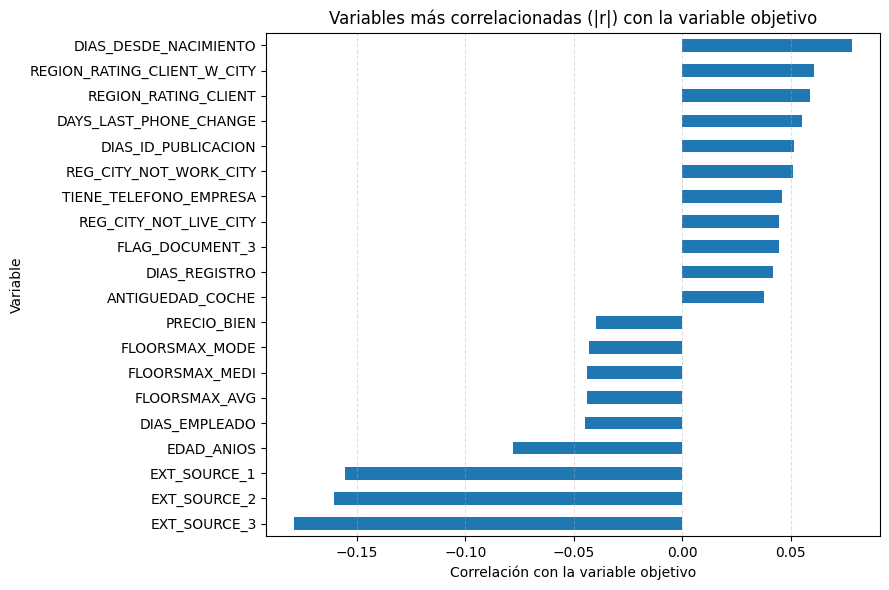

In [105]:
# === 6) Correlaciones iniciales (screening rápido) ===
import numpy as np
import matplotlib.pyplot as plt

def pick(df, *candidatas):
    for c in candidatas:
        if c in df.columns:
            return c
    return None

target_col = pick(app_train, "IMPAGO", "TARGET")
id_col     = pick(app_train, "ID_CLIENTE", "SK_ID_CURR")

# Correlación con la variable objetivo (solo numéricas)
num_cols = app_train.select_dtypes(include=[np.number]).columns.tolist()
# excluir ID y la propia TARGET/IMPAGO
for ex in [id_col, target_col]:
    if ex in num_cols:
        num_cols.remove(ex)

corr = app_train[num_cols].corrwith(app_train[target_col]).dropna() if target_col else pd.Series(dtype=float)

# Top 20 en valor absoluto
top20 = corr.reindex(corr.abs().sort_values(ascending=False).head(20).index)

plt.figure(figsize=(9,6))
(top20.sort_values()).plot(kind="barh")
plt.title("Variables más correlacionadas (|r|) con la variable objetivo")
plt.xlabel("Correlación con la variable objetivo")
plt.ylabel("Variable")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Dejar a mano series para el informe (celda 7)
corr_target = corr.sort_values(key=np.abs, ascending=False)
protect_df  = corr_target[corr_target < 0].head(10).to_frame("Correlación").rename_axis("Variable").reset_index()
risk_df     = corr_target[corr_target > 0].head(10).to_frame("Correlación").rename_axis("Variable").reset_index()


In [106]:
# 6.1) Categóricas: tasa de impago por categoría (top diferencias absolutas) — robusto ES/EN

import pandas as pd
import numpy as np
from IPython.display import display

def pick(df, *candidatas):
    """Devuelve la primera columna existente en df de una lista de candidatas."""
    for c in candidatas:
        if c in df.columns:
            return c
    return None

target_col = pick(app_train, "IMPAGO", "TARGET")
if target_col is None:
    raise ValueError("No se encontró la variable objetivo (IMPAGO/TARGET).")

# Función para calcular tasas por categoría con lift vs tasa global
def risk_by_cat(col, min_count=2000):
    tmp = (
        app_train.groupby(col)[target_col]
        .agg(rate="mean", n="size")
        .query("n >= @min_count")
        .sort_values("rate", ascending=False)
        .reset_index()
    )
    tmp["lift_vs_global"] = tmp["rate"] - app_train[target_col].mean()
    return tmp

# Columnas categóricas disponibles
cats = app_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Lista lógica de variables categóricas a revisar (pares ES/EN)
cands = [
    pick(app_train, "TIPO_CONTRATO",        "NAME_CONTRACT_TYPE"),
    pick(app_train, "SEXO",                 "CODE_GENDER"),
    pick(app_train, "POSEE_COCHE",          "FLAG_OWN_CAR"),
    pick(app_train, "POSEE_VIVIENDA",       "FLAG_OWN_REALTY"),
    pick(app_train, "TIPO_INGRESO",         "NAME_INCOME_TYPE"),
    pick(app_train, "EDUCACION",            "NAME_EDUCATION_TYPE"),
    pick(app_train, "ESTADO_FAMILIAR",      "NAME_FAMILY_STATUS"),
    pick(app_train, "TIPO_VIVIENDA",        "NAME_HOUSING_TYPE"),
    pick(app_train, "OCUPACION",            "OCCUPATION_TYPE"),
    pick(app_train, "ORGANIZACION",         "ORGANIZATION_TYPE"),
    pick(app_train, "DIA_SEMANA_SOLICITUD", "WEEKDAY_APPR_PROCESS_START"),
]

# Nos quedamos solo con las que existen y son categóricas
cols_ok = [c for c in cands if c is not None and c in cats]

# Ejecutamos y mostramos top-10 por |lift|
resultados = {}
for c in cols_ok:
    dfc = risk_by_cat(c)
    if not dfc.empty:
        dfc = dfc.reindex(dfc["lift_vs_global"].abs().sort_values(ascending=False).index)
        resultados[c] = dfc

for k, v in resultados.items():
    print(f"\n▶ {k}")
    display(v.head(10))



▶ TIPO_CONTRATO


,TIPO_CONTRATO,rate,n,lift_vs_global
1,Revolving loans,0.054783,29279,-0.025946
0,Cash loans,0.083459,278232,0.002730



▶ SEXO


,SEXO,rate,n,lift_vs_global
0,M,0.101419,105059,0.020690
1,F,0.069993,202448,-0.010736



▶ POSEE_COCHE


,POSEE_COCHE,rate,n,lift_vs_global
1,Y,0.072437,104587,-0.008292
0,N,0.085002,202924,0.004273



▶ POSEE_VIVIENDA


,POSEE_VIVIENDA,rate,n,lift_vs_global
0,N,0.083249,94199,0.002520
1,Y,0.079616,213312,-0.001113



▶ NAME_INCOME_TYPE


,NAME_INCOME_TYPE,rate,n,lift_vs_global
3,Pensioner,0.053864,55362,-0.026865
2,State servant,0.057550,21703,-0.023179
0,Working,0.095885,158774,0.015156
1,Commercial associate,0.074843,71617,-0.005886



▶ NAME_EDUCATION_TYPE


,NAME_EDUCATION_TYPE,rate,n,lift_vs_global
0,Lower secondary,0.109277,3816,0.028548
3,Higher education,0.053551,74863,-0.027178
1,Secondary / secondary special,0.089399,218391,0.008670
2,Incomplete higher,0.084850,10277,0.004121



▶ NAME_FAMILY_STATUS


,NAME_FAMILY_STATUS,rate,n,lift_vs_global
4,Widow,0.058242,16088,-0.022487
0,Civil marriage,0.099446,29775,0.018717
1,Single / not married,0.098077,45444,0.017348
3,Married,0.075599,196432,-0.005130
2,Separated,0.081942,19770,0.001214



▶ NAME_HOUSING_TYPE


,NAME_HOUSING_TYPE,rate,n,lift_vs_global
0,Rented apartment,0.123131,4881,0.042402
1,With parents,0.116981,14840,0.036252
4,Office apartment,0.065724,2617,-0.015005
2,Municipal apartment,0.085397,11183,0.004669
3,House / apartment,0.077957,272868,-0.002772



▶ OCCUPATION_TYPE


,OCCUPATION_TYPE,rate,n,lift_vs_global
0,Low-skill Laborers,0.171524,2093,0.090795
1,Drivers,0.113261,18603,0.032532
12,Accountants,0.048303,9813,-0.032426
2,Security staff,0.107424,6721,0.026696
3,Laborers,0.105788,55186,0.025059
4,Cooking staff,0.104440,5946,0.023711
11,High skill tech staff,0.061599,11380,-0.019130
10,Managers,0.062140,21371,-0.018589
9,Core staff,0.063040,27570,-0.017689
5,Sales staff,0.096318,32102,0.015589



▶ ORGANIZATION_TYPE


,ORGANIZATION_TYPE,rate,n,lift_vs_global
0,Construction,0.116798,6721,0.036069
24,Police,0.049979,2341,-0.030750
23,Military,0.051253,2634,-0.029476
22,Bank,0.051855,2507,-0.028874
21,XNA,0.053996,55374,-0.026732
1,Industry: type 3,0.106162,3278,0.025433
2,Agriculture,0.104727,2454,0.023998
3,Trade: type 3,0.103379,3492,0.022650
20,School,0.059148,8893,-0.021581
4,Self-employed,0.101739,38412,0.021010



▶ WEEKDAY_APPR_PROCESS_START


,WEEKDAY_APPR_PROCESS_START,rate,n,lift_vs_global
6,MONDAY,0.077572,50714,-0.003157
0,TUESDAY,0.083505,53901,0.002776
5,SATURDAY,0.078873,33852,-0.001856
4,SUNDAY,0.079291,16181,-0.001438
1,WEDNESDAY,0.081604,51934,0.000875
2,FRIDAY,0.081469,50338,0.000740
3,THURSDAY,0.081003,50591,0.000274


In [107]:
# 6.1) Categóricas: tasa de impago por categoría (top diferencias absolutas) — versión correcta

import pandas as pd
import numpy as np
from IPython.display import display

def seleccionar_columna(df, *opciones):
    """Devuelve la primera columna existente en el DataFrame de entre 'opciones'."""
    for col in opciones:
        if col in df.columns:
            return col
    return None

# Objetivo (IMPAGO si existe, si no TARGET)
col_objetivo = seleccionar_columna(app_train, "IMPAGO", "TARGET")
if col_objetivo is None:
    raise ValueError("⚠️ No se encontró la variable objetivo (IMPAGO o TARGET).")

def tasa_impago_por_categoria(columna, minimo=2000):
    """Tasa de impago por categoría + diferencia respecto a la tasa global."""
    tmp = (
        app_train.groupby(columna)[col_objetivo]
        .agg(tasa_impago="mean", n="size")
        .query("n >= @minimo")
        .sort_values("tasa_impago", ascending=False)
        .reset_index()
    )
    tmp["diferencia_vs_global"] = tmp["tasa_impago"] - app_train[col_objetivo].mean()
    return tmp

# Categóricas del DataFrame
categoricas = app_train.select_dtypes(include=["object", "category"]).columns.tolist()

# Candidatas (pares ES/EN)
columnas_candidatas = [
    seleccionar_columna(app_train, "TIPO_CONTRATO",        "NAME_CONTRACT_TYPE"),
    seleccionar_columna(app_train, "SEXO",                 "CODE_GENDER"),
    seleccionar_columna(app_train, "POSEE_COCHE",          "FLAG_OWN_CAR"),
    seleccionar_columna(app_train, "POSEE_VIVIENDA",       "FLAG_OWN_REALTY"),
    seleccionar_columna(app_train, "TIPO_INGRESO",         "NAME_INCOME_TYPE"),
    seleccionar_columna(app_train, "EDUCACION",            "NAME_EDUCATION_TYPE"),
    seleccionar_columna(app_train, "ESTADO_FAMILIAR",      "NAME_FAMILY_STATUS"),
    seleccionar_columna(app_train, "TIPO_VIVIENDA",        "NAME_HOUSING_TYPE"),
    seleccionar_columna(app_train, "OCUPACION",            "OCCUPATION_TYPE"),
    seleccionar_columna(app_train, "ORGANIZACION",         "ORGANIZATION_TYPE"),
    seleccionar_columna(app_train, "DIA_SEMANA_SOLICITUD", "WEEKDAY_APPR_PROCESS_START"),
]

# ✅ Aquí estaba el fallo: filtrar bien las columnas válidas
columnas_validas = [c for c in columnas_candidatas if (c is not None) and (c in categoricas)]

# Calculamos y mostramos top-10 por impacto absoluto
resultados = {}
for col in columnas_validas:
    df_categoria = tasa_impago_por_categoria(col)
    if not df_categoria.empty:
        df_categoria = df_categoria.reindex(
            df_categoria["diferencia_vs_global"].abs().sort_values(ascending=False).index
        )
        resultados[col] = df_categoria

for nombre, df_res in resultados.items():
    print(f"\n📊 Variable categórica: {nombre}")
    display(df_res.head(10))




📊 Variable categórica: TIPO_CONTRATO


,TIPO_CONTRATO,tasa_impago,n,diferencia_vs_global
1,Revolving loans,0.054783,29279,-0.025946
0,Cash loans,0.083459,278232,0.002730



📊 Variable categórica: SEXO


,SEXO,tasa_impago,n,diferencia_vs_global
0,M,0.101419,105059,0.020690
1,F,0.069993,202448,-0.010736



📊 Variable categórica: POSEE_COCHE


,POSEE_COCHE,tasa_impago,n,diferencia_vs_global
1,Y,0.072437,104587,-0.008292
0,N,0.085002,202924,0.004273



📊 Variable categórica: POSEE_VIVIENDA


,POSEE_VIVIENDA,tasa_impago,n,diferencia_vs_global
0,N,0.083249,94199,0.002520
1,Y,0.079616,213312,-0.001113



📊 Variable categórica: NAME_INCOME_TYPE


,NAME_INCOME_TYPE,tasa_impago,n,diferencia_vs_global
3,Pensioner,0.053864,55362,-0.026865
2,State servant,0.057550,21703,-0.023179
0,Working,0.095885,158774,0.015156
1,Commercial associate,0.074843,71617,-0.005886



📊 Variable categórica: NAME_EDUCATION_TYPE


,NAME_EDUCATION_TYPE,tasa_impago,n,diferencia_vs_global
0,Lower secondary,0.109277,3816,0.028548
3,Higher education,0.053551,74863,-0.027178
1,Secondary / secondary special,0.089399,218391,0.008670
2,Incomplete higher,0.084850,10277,0.004121



📊 Variable categórica: NAME_FAMILY_STATUS


,NAME_FAMILY_STATUS,tasa_impago,n,diferencia_vs_global
4,Widow,0.058242,16088,-0.022487
0,Civil marriage,0.099446,29775,0.018717
1,Single / not married,0.098077,45444,0.017348
3,Married,0.075599,196432,-0.005130
2,Separated,0.081942,19770,0.001214



📊 Variable categórica: NAME_HOUSING_TYPE


,NAME_HOUSING_TYPE,tasa_impago,n,diferencia_vs_global
0,Rented apartment,0.123131,4881,0.042402
1,With parents,0.116981,14840,0.036252
4,Office apartment,0.065724,2617,-0.015005
2,Municipal apartment,0.085397,11183,0.004669
3,House / apartment,0.077957,272868,-0.002772



📊 Variable categórica: OCCUPATION_TYPE


,OCCUPATION_TYPE,tasa_impago,n,diferencia_vs_global
0,Low-skill Laborers,0.171524,2093,0.090795
1,Drivers,0.113261,18603,0.032532
12,Accountants,0.048303,9813,-0.032426
2,Security staff,0.107424,6721,0.026696
3,Laborers,0.105788,55186,0.025059
4,Cooking staff,0.104440,5946,0.023711
11,High skill tech staff,0.061599,11380,-0.019130
10,Managers,0.062140,21371,-0.018589
9,Core staff,0.063040,27570,-0.017689
5,Sales staff,0.096318,32102,0.015589



📊 Variable categórica: ORGANIZATION_TYPE


,ORGANIZATION_TYPE,tasa_impago,n,diferencia_vs_global
0,Construction,0.116798,6721,0.036069
24,Police,0.049979,2341,-0.030750
23,Military,0.051253,2634,-0.029476
22,Bank,0.051855,2507,-0.028874
21,XNA,0.053996,55374,-0.026732
1,Industry: type 3,0.106162,3278,0.025433
2,Agriculture,0.104727,2454,0.023998
3,Trade: type 3,0.103379,3492,0.022650
20,School,0.059148,8893,-0.021581
4,Self-employed,0.101739,38412,0.021010



📊 Variable categórica: WEEKDAY_APPR_PROCESS_START


,WEEKDAY_APPR_PROCESS_START,tasa_impago,n,diferencia_vs_global
6,MONDAY,0.077572,50714,-0.003157
0,TUESDAY,0.083505,53901,0.002776
5,SATURDAY,0.078873,33852,-0.001856
4,SUNDAY,0.079291,16181,-0.001438
1,WEDNESDAY,0.081604,51934,0.000875
2,FRIDAY,0.081469,50338,0.000740
3,THURSDAY,0.081003,50591,0.000274



📈 Variable numérica: EDAD_ANIOS


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,EDAD_ANIOS,20.503,28.156,24.3295,30752,0.115700,0.034971
1,EDAD_ANIOS,28.156,32.016,30.0860,30760,0.109948,0.029219
2,EDAD_ANIOS,32.016,35.975,33.9955,30745,0.098065,0.017336
3,EDAD_ANIOS,35.975,39.469,37.7220,30759,0.088527,0.007798
4,EDAD_ANIOS,39.469,43.121,41.2950,30745,0.079037,-0.001692
5,EDAD_ANIOS,43.121,47.146,45.1335,30764,0.077948,-0.002781
6,EDAD_ANIOS,47.146,51.704,49.4250,30733,0.071357,-0.009372
7,EDAD_ANIOS,51.704,56.055,53.8795,30758,0.063431,-0.017298
8,EDAD_ANIOS,56.055,60.728,58.3915,30757,0.054232,-0.026497
9,EDAD_ANIOS,60.728,69.073,64.9005,30738,0.049027,-0.031702


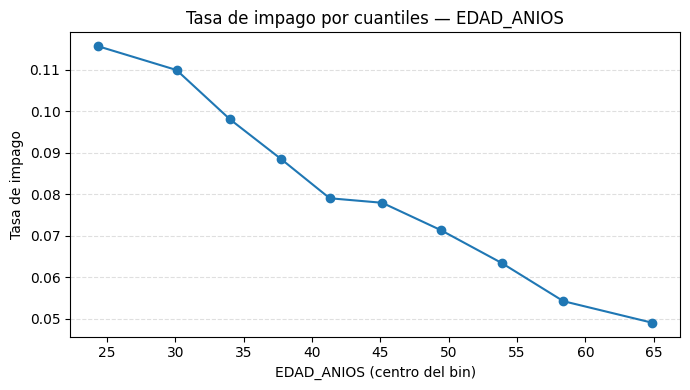


📈 Variable numérica: RATIO_CREDITO_INGRESO


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,RATIO_CREDITO_INGRESO,0.00381,1.332,0.667905,30759,0.069085,-0.011643
1,RATIO_CREDITO_INGRESO,1.33200,1.818,1.575000,30780,0.077615,-0.003113
2,RATIO_CREDITO_INGRESO,1.81800,2.266,2.042000,30730,0.081126,0.000397
3,RATIO_CREDITO_INGRESO,2.26600,2.764,2.515000,30772,0.090212,0.009483
4,RATIO_CREDITO_INGRESO,2.76400,3.265,3.014500,30725,0.086542,0.005813
5,RATIO_CREDITO_INGRESO,3.26500,3.906,3.585500,30741,0.091962,0.011233
6,RATIO_CREDITO_INGRESO,3.90600,4.725,4.315500,30754,0.086168,0.005439
7,RATIO_CREDITO_INGRESO,4.72500,5.769,5.247000,30751,0.079510,-0.001219
8,RATIO_CREDITO_INGRESO,5.76900,7.488,6.628500,30815,0.074412,-0.006317
9,RATIO_CREDITO_INGRESO,7.48800,84.737,46.112500,30684,0.070656,-0.010073


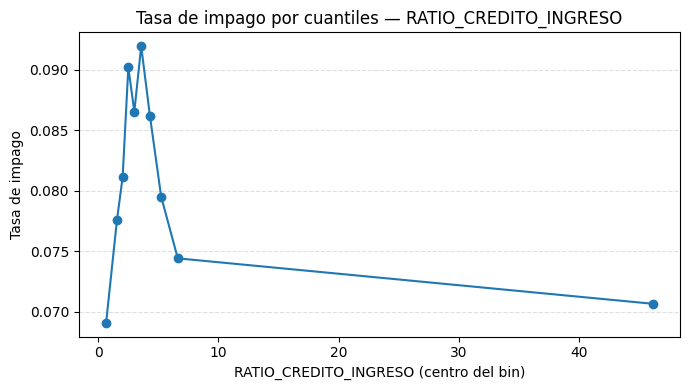


📈 Variable numérica: INGRESO_TOTAL


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,INGRESO_TOTAL,25649.999,81000.0,5.332500e+04,33391,0.081908,0.001179
1,INGRESO_TOTAL,81000.000,99000.0,9.000000e+04,30280,0.082232,0.001504
2,INGRESO_TOTAL,99000.000,112500.0,1.057500e+05,36907,0.087192,0.006463
3,INGRESO_TOTAL,112500.000,135000.0,1.237500e+05,48849,0.084894,0.004165
4,INGRESO_TOTAL,135000.000,147150.0,1.410750e+05,4333,0.090007,0.009278
5,INGRESO_TOTAL,147150.000,162000.0,1.545750e+05,31120,0.086407,0.005679
6,INGRESO_TOTAL,162000.000,180000.0,1.710000e+05,30704,0.084224,0.003495
7,INGRESO_TOTAL,180000.000,225000.0,2.025000e+05,44809,0.078065,-0.002664
8,INGRESO_TOTAL,225000.000,270000.0,2.475000e+05,19957,0.070401,-0.010327
9,INGRESO_TOTAL,270000.000,117000000.0,5.863500e+07,27161,0.061375,-0.019354


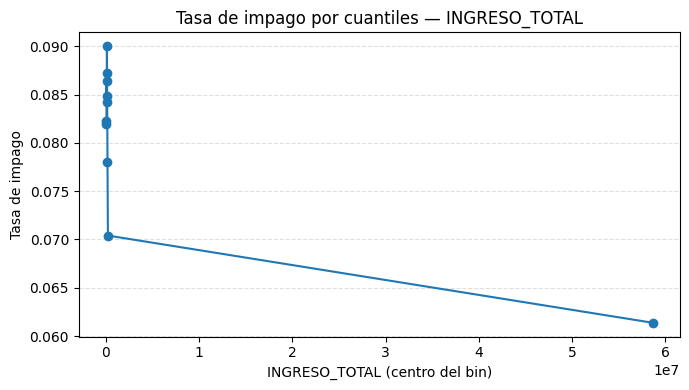


📈 Variable numérica: CREDITO_SOLICITADO


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,CREDITO_SOLICITADO,44999.999,180000.0,1.125000e+05,33204,0.067221,-0.013508
1,CREDITO_SOLICITADO,180000.000,254700.0,2.173500e+05,31721,0.077772,-0.002957
2,CREDITO_SOLICITADO,254700.000,306306.0,2.805030e+05,27391,0.082071,0.001342
3,CREDITO_SOLICITADO,306306.000,432000.0,3.691530e+05,30707,0.100335,0.019607
4,CREDITO_SOLICITADO,432000.000,513531.0,4.727655e+05,30826,0.095893,0.015164
5,CREDITO_SOLICITADO,513531.000,604152.0,5.588415e+05,30726,0.105220,0.024492
6,CREDITO_SOLICITADO,604152.000,755190.0,6.796710e+05,34066,0.085364,0.004635
7,CREDITO_SOLICITADO,755190.000,900000.0,8.275950e+05,29958,0.070799,-0.009930
8,CREDITO_SOLICITADO,900000.000,1133748.0,1.016874e+06,28319,0.068823,-0.011906
9,CREDITO_SOLICITADO,1133748.000,4050000.0,2.591874e+06,30593,0.053280,-0.027449


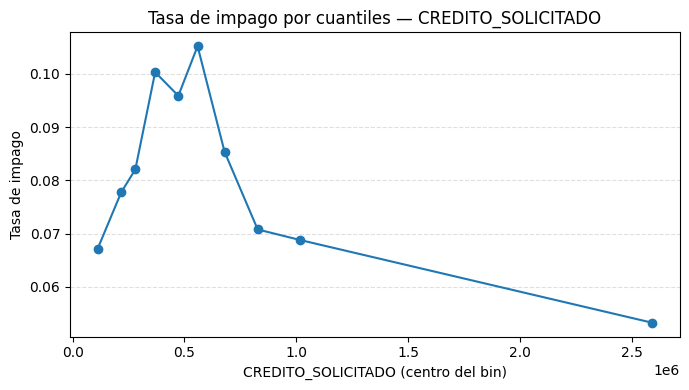


📈 Variable numérica: ANUALIDAD


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,ANUALIDAD,1615.499,11074.5,6344.9995,30880,0.071049,-0.009680
1,ANUALIDAD,11074.500,14701.5,12888.0000,30627,0.067914,-0.012815
2,ANUALIDAD,14701.500,18189.0,16445.2500,30763,0.084777,0.004048
3,ANUALIDAD,18189.000,21865.5,20027.2500,30731,0.086883,0.006154
4,ANUALIDAD,21865.500,24903.0,23384.2500,30772,0.084752,0.004024
5,ANUALIDAD,24903.000,28062.0,26482.5000,30790,0.091069,0.010340
6,ANUALIDAD,28062.000,32004.0,30033.0000,30690,0.100815,0.020086
7,ANUALIDAD,32004.000,37516.5,34760.2500,30762,0.085983,0.005254
8,ANUALIDAD,37516.500,45954.0,41735.2500,30808,0.076214,-0.004515
9,ANUALIDAD,45954.000,258025.5,151989.7500,30676,0.057830,-0.022899


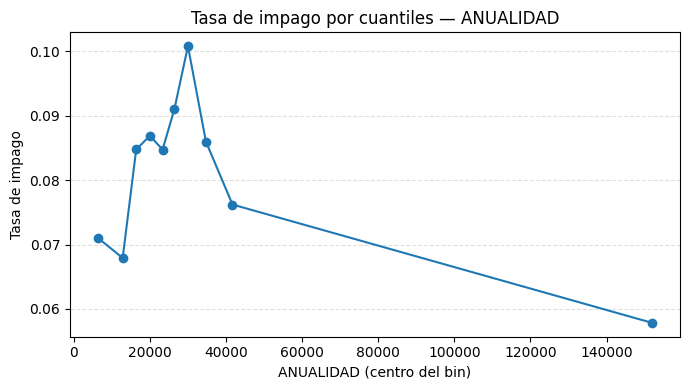


📈 Variable numérica: PRECIO_BIEN


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,PRECIO_BIEN,40499.999,180000.0,1.102500e+05,39484,0.072865,-0.007864
1,PRECIO_BIEN,180000.000,225000.0,2.025000e+05,31970,0.089084,0.008355
2,PRECIO_BIEN,225000.000,270000.0,2.475000e+05,27990,0.077313,-0.003415
3,PRECIO_BIEN,270000.000,373500.0,3.217500e+05,23483,0.100583,0.019855
4,PRECIO_BIEN,373500.000,450000.0,4.117500e+05,35052,0.132717,0.051988
5,PRECIO_BIEN,450000.000,522000.0,4.860000e+05,26475,0.065420,-0.015309
6,PRECIO_BIEN,522000.000,675000.0,5.985000e+05,42417,0.084636,0.003907
7,PRECIO_BIEN,675000.000,814500.0,7.447500e+05,18932,0.055990,-0.024739
8,PRECIO_BIEN,814500.000,1093500.0,9.540000e+05,30745,0.065442,-0.015287
9,PRECIO_BIEN,1093500.000,4050000.0,2.571750e+06,30685,0.049112,-0.031617


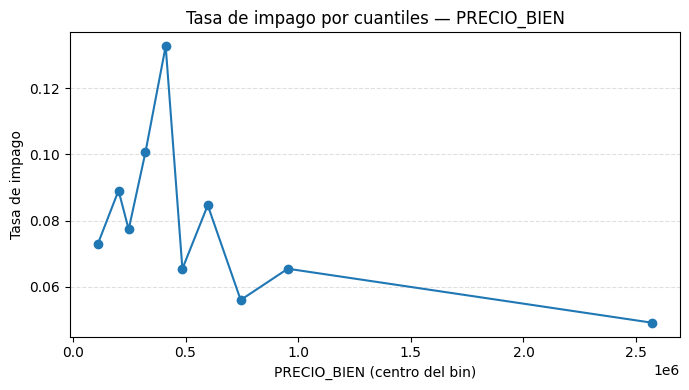


📈 Variable numérica: EXT_SOURCE_1


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,EXT_SOURCE_1,0.0136,0.213,0.1133,13414,0.175637,0.094909
1,EXT_SOURCE_1,0.2130,0.296,0.2545,13413,0.115932,0.035203
2,EXT_SOURCE_1,0.2960,0.369,0.3325,13414,0.090950,0.010221
3,EXT_SOURCE_1,0.3690,0.438,0.4035,13412,0.083806,0.003077
4,EXT_SOURCE_1,0.4380,0.506,0.4720,13415,0.066940,-0.013789
5,EXT_SOURCE_1,0.5060,0.573,0.5395,13412,0.060245,-0.020484
6,EXT_SOURCE_1,0.5730,0.640,0.6065,13413,0.051368,-0.029361
7,EXT_SOURCE_1,0.6400,0.710,0.6750,13413,0.043838,-0.036891
8,EXT_SOURCE_1,0.7100,0.787,0.7485,13413,0.035115,-0.045614
9,EXT_SOURCE_1,0.7870,0.963,0.8750,13414,0.025719,-0.055009


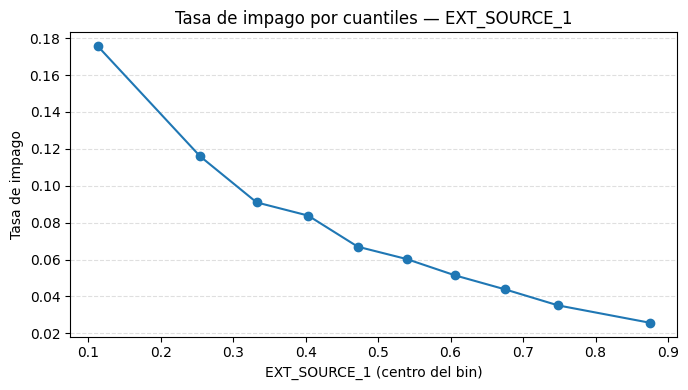


📈 Variable numérica: EXT_SOURCE_2


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,EXT_SOURCE_2,-0.001,0.216,0.1075,30686,0.183504,0.102775
1,EXT_SOURCE_2,0.216,0.340,0.2780,30685,0.120776,0.040047
2,EXT_SOURCE_2,0.340,0.440,0.3900,30687,0.099586,0.018857
3,EXT_SOURCE_2,0.440,0.512,0.4760,30684,0.083627,0.002898
4,EXT_SOURCE_2,0.512,0.566,0.5390,30684,0.074241,-0.006488
5,EXT_SOURCE_2,0.566,0.608,0.5870,30687,0.066543,-0.014186
6,EXT_SOURCE_2,0.608,0.646,0.6270,30683,0.058469,-0.022260
7,EXT_SOURCE_2,0.646,0.682,0.6640,30694,0.048837,-0.031892
8,EXT_SOURCE_2,0.682,0.722,0.7020,30676,0.042020,-0.038709
9,EXT_SOURCE_2,0.722,0.855,0.7885,30685,0.029721,-0.051007


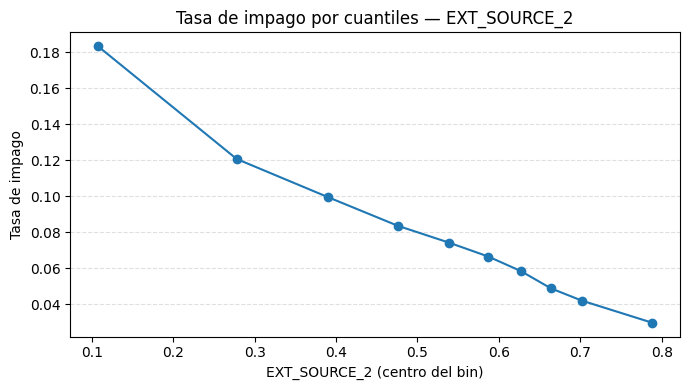


📈 Variable numérica: EXT_SOURCE_3


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,EXT_SOURCE_3,-0.000473,0.228,0.113764,24701,0.200032,0.119304
1,EXT_SOURCE_3,0.228000,0.330,0.279000,24744,0.127546,0.046817
2,EXT_SOURCE_3,0.330000,0.408,0.369000,25057,0.095103,0.014374
3,EXT_SOURCE_3,0.408000,0.476,0.442000,24689,0.079793,-0.000936
4,EXT_SOURCE_3,0.476000,0.535,0.505500,24186,0.061771,-0.018958
5,EXT_SOURCE_3,0.535000,0.592,0.563500,25392,0.053442,-0.027287
6,EXT_SOURCE_3,0.592000,0.643,0.617500,24725,0.047442,-0.033287
7,EXT_SOURCE_3,0.643000,0.694,0.668500,24745,0.042150,-0.038579
8,EXT_SOURCE_3,0.694000,0.749,0.721500,23675,0.035312,-0.045417
9,EXT_SOURCE_3,0.749000,0.896,0.822500,24632,0.032275,-0.048454


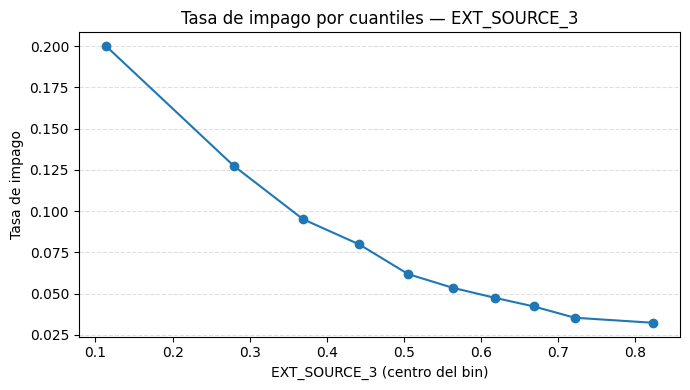


📈 Variable numérica: N_HIJOS


,variable,bin_left,bin_right,center,n,rate,diferencia_vs_global
0,N_HIJOS,-0.001,1.0,0.4995,276490,0.079797,-0.000932
1,N_HIJOS,1.000,2.0,1.5000,26749,0.087218,0.006489
2,N_HIJOS,2.000,19.0,10.5000,4272,0.100421,0.019693


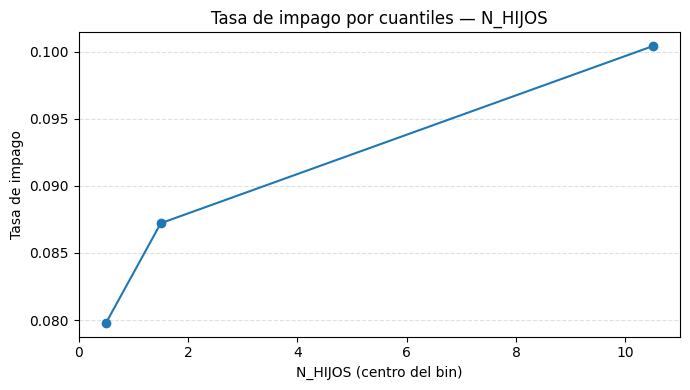


🏁 Variables numéricas con mayor impacto (máx |lift| entre bins):


,variable,max_abs_lift
8,EXT_SOURCE_3,0.119304
7,EXT_SOURCE_2,0.102775
6,EXT_SOURCE_1,0.094909
5,PRECIO_BIEN,0.051988
0,EDAD_ANIOS,0.034971
3,CREDITO_SOLICITADO,0.027449
4,ANUALIDAD,0.022899
9,N_HIJOS,0.019693
2,INGRESO_TOTAL,0.019354
1,RATIO_CREDITO_INGRESO,0.011643


In [108]:
# 6.2) Numéricas: tasa de impago por cuantiles (lift vs global) — robusto ES/EN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Helper para escoger columna disponible (ES o EN)
def pick(df, *candidatas):
    for c in candidatas:
        if c in df.columns:
            return c
    return None

target_col = pick(app_train, "IMPAGO", "TARGET")
if target_col is None:
    raise ValueError("⚠️ No se encontró la variable objetivo (IMPAGO/TARGET).")

global_rate = app_train[target_col].mean()

# --- función principal: tasa de impago por cuantiles para una variable numérica ---
def risk_by_num(col, q=10, min_count=2000):
    """
    Devuelve una tabla con tasa de impago por cuantiles de 'col',
    número de observaciones por bin y lift vs la tasa global.
    """
    s = app_train[col].replace([np.inf, -np.inf], np.nan).dropna()
    # Poca variabilidad ⇒ no analizamos
    if s.nunique() < 5:
        return None

    # Construimos cuantiles (evitando duplicados)
    try:
        qb = pd.qcut(s, q=min(q, s.nunique()), duplicates="drop")
    except ValueError:
        return None

    # Agregamos tasa y frecuencias
    tmp = (
        app_train.loc[s.index]
        .groupby(qb)[target_col]
        .agg(rate="mean", n="size")
        .reset_index(drop=False)
        .rename(columns={"index": "bin"})
    )

    # Extraemos bordes y centro del bin para graficar
    cats = qb.cat.categories
    tmp["bin_left"]  = cats.left.values
    tmp["bin_right"] = cats.right.values
    tmp["center"]    = (tmp["bin_left"] + tmp["bin_right"]) / 2

    tmp["diferencia_vs_global"] = tmp["rate"] - global_rate
    tmp["variable"] = col

    # Filtramos bins con muy pocos casos si se pide
    if min_count is not None and min_count > 0:
        tmp = tmp.loc[tmp["n"] >= min_count].copy()
        if tmp.empty:
            return None

    cols = ["variable", "bin_left", "bin_right", "center", "n", "rate", "diferencia_vs_global"]
    return tmp[cols].sort_values("center")

# --- candidatos numéricos (pares ES/EN) ---
num_cands = [
    pick(app_train, "EDAD_ANIOS", None),
    pick(app_train, "RATIO_CREDITO_INGRESO", None),
    pick(app_train, "INGRESO_TOTAL", "AMT_INCOME_TOTAL"),
    pick(app_train, "CREDITO_SOLICITADO", "AMT_CREDIT"),
    pick(app_train, "ANUALIDAD", "AMT_ANNUITY"),
    pick(app_train, "PRECIO_BIEN", "AMT_GOODS_PRICE"),
    pick(app_train, "FUENTE_EXTERNA_1", "EXT_SOURCE_1"),
    pick(app_train, "FUENTE_EXTERNA_2", "EXT_SOURCE_2"),
    pick(app_train, "FUENTE_EXTERNA_3", "EXT_SOURCE_3"),
    pick(app_train, "N_HIJOS", "CNT_CHILDREN"),
]

# Nos quedamos con las columnas que existan y sean numéricas
num_cols_df = app_train.select_dtypes(include=[np.number]).columns.tolist()
num_vars = [c for c in num_cands if (c is not None) and (c in num_cols_df)]

# --- Ejecutamos análisis y graficamos por variable ---
resultados_num = {}

for col in num_vars:
    dfq = risk_by_num(col, q=10, min_count=2000)
    if dfq is None or dfq.empty:
        continue
    resultados_num[col] = dfq

    print(f"\n📈 Variable numérica: {col}")
    display(dfq.head(10))  # primeras filas para inspección

    # Gráfico tasa de impago por cuantiles
    plt.figure(figsize=(7,4))
    plt.plot(dfq["center"], dfq["rate"], marker="o")
    plt.title(f"Tasa de impago por cuantiles — {col}")
    plt.xlabel(f"{col} (centro del bin)")
    plt.ylabel("Tasa de impago")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# (Opcional) Identificar variables con mayor impacto máximo (|lift|) entre sus bins
if resultados_num:
    impacto = []
    for col, dfq in resultados_num.items():
        impacto.append((col, dfq["diferencia_vs_global"].abs().max()))
    impacto = pd.DataFrame(impacto, columns=["variable", "max_abs_lift"]).sort_values("max_abs_lift", ascending=False)
    print("\n🏁 Variables numéricas con mayor impacto (máx |lift| entre bins):")
    display(impacto.head(10))
else:
    print("No se generó análisis numérico (quizá las columnas no cumplen los requisitos).")


In [109]:
!pip install seaborn


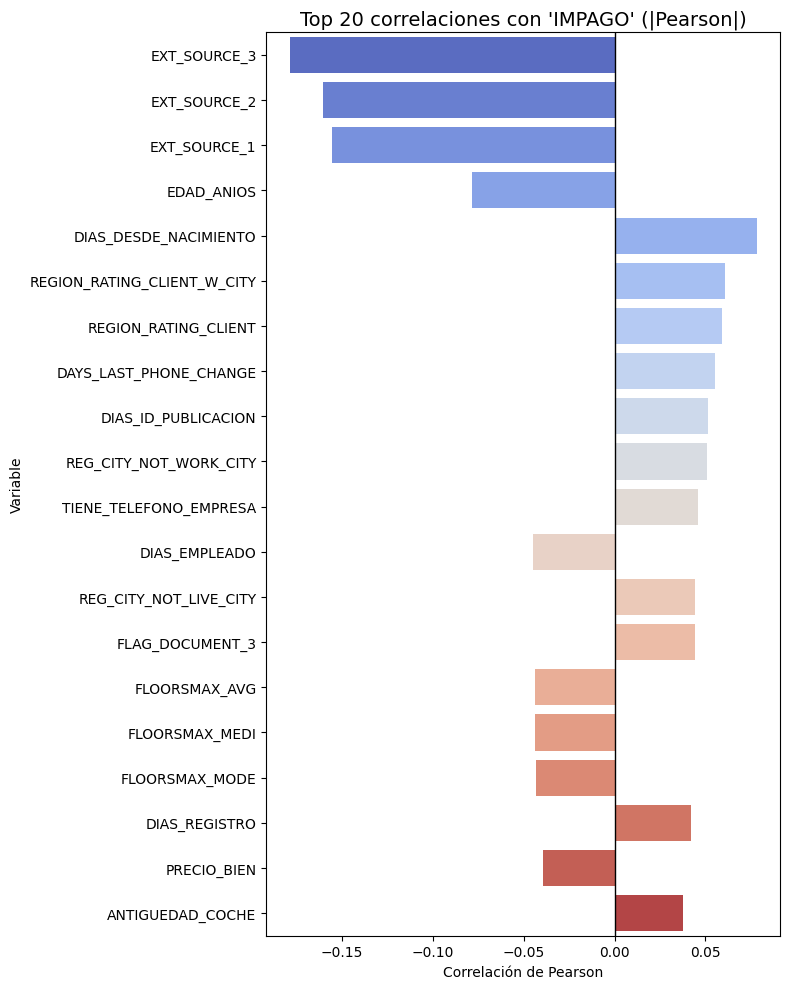

In [111]:
# Correlaciones con la variable objetivo (usando Seaborn)

import seaborn as sns
import matplotlib.pyplot as plt

# Detectar automáticamente el nombre de la variable objetivo (TARGET o IMPAGO)
target_col = "IMPAGO" if "IMPAGO" in app_train.columns else "TARGET"

# Calcular correlaciones solo con variables numéricas
corr_target = app_train.corr(numeric_only=True)[target_col].sort_values(key=abs, ascending=False)

# Seleccionar las 20 variables más correlacionadas con la variable objetivo
top_corr = corr_target.head(21).drop(target_col)

plt.figure(figsize=(8, 10))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    palette="coolwarm"
)

plt.axvline(0, color="black", linewidth=1)
plt.title(f"Top {len(top_corr)} correlaciones con '{target_col}' (|Pearson|)", fontsize=14)
plt.xlabel("Correlación de Pearson")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [16]:
!pip install tabulate


## 7) Conclusiones del EDA

In [3]:
# 7) Resumen del EDA — versión robusta y sin dependencias extra (autosuficiente)

import os
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

# --------- Bootstrap: obtén app_train desde variables previas o desde CSV ---------
def _get_app_train():
    g = globals()
    # 1) Si ya existe en memoria con alguno de estos nombres, úsalo
    for cand in ("app_train", "application_train", "train_df", "df_train", "df"):
        if cand in g and isinstance(g[cand], pd.DataFrame):
            return g[cand].copy()

    # 2) Si no existe, intenta cargar desde disco (ajusta rutas si hace falta)
    candidates = [
        "../../data/raw/home-credit-default-risk/application_train.csv",
        "../input/home-credit-default-risk/application_train.csv",
        "application_train.csv",
    ]
    for p in candidates:
        if os.path.exists(p):
            print(f"[info] Cargando app_train desde: {p}")
            return pd.read_csv(p)

    raise NameError(
        "No encontré 'app_train' en memoria ni pude cargar 'application_train.csv'. "
        "Ajusta la ruta en 'candidates' o define app_train antes."
    )

app_train = _get_app_train()

# --------- Utilidad para elegir nombres ES/EN ---------
def pick(df, *candidatas):
    for c in candidatas:
        if c in df.columns:
            return c
    return None

# Columnas clave (soporta ES/EN)
id_col     = pick(app_train, "ID_CLIENTE", "SK_ID_CURR")
target_col = pick(app_train, "IMPAGO", "TARGET")

if target_col is None:
    raise ValueError("No se encontró la variable objetivo (IMPAGO/TARGET).")

# Helper: render de tabla Markdown sin depender de 'tabulate'
def md_table(df, max_rows=10):
    df2 = df.copy()
    try:
        return "\n" + df2.head(max_rows).to_markdown(index=False) + "\n"
    except Exception:
        return "\n```\n" + df2.head(max_rows).to_string(index=False) + "\n```\n"

# Métricas generales
n_rows  = len(app_train)
n_cols  = app_train.shape[1]
mem_mb  = app_train.memory_usage(deep=True).sum() / (1024*1024)
global_rate = float(app_train[target_col].mean())

# Top nulos (top 10)
top_nulls_df = (
    app_train.isnull().mean().sort_values(ascending=False).head(10)*100
).round(1).to_frame("% Nulos").rename_axis("Variable").reset_index()

# Correlaciones
num_cols = app_train.select_dtypes(include=[np.number]).columns.tolist()
for ex in [id_col, target_col]:
    if ex in num_cols:
        num_cols.remove(ex)

corr_target = (
    app_train[num_cols]
    .corrwith(app_train[target_col])
    .dropna()
    .sort_values(key=np.abs, ascending=False)
)

protect_df = corr_target[corr_target < 0].head(10).to_frame("Correlación").rename_axis("Variable").reset_index()
risk_df    = corr_target[corr_target > 0].head(10).to_frame("Correlación").rename_axis("Variable").reset_index()

# Listas de la sección 4 si existen
ALTOS  = globals().get("ALTOS",  [])
MEDIOS = globals().get("MEDIOS", [])
BAJOS  = globals().get("BAJOS",  [])

# --------- Informe ----------
md = f"""
## 🧠 Resumen del EDA

Este documento resume los principales hallazgos del análisis exploratorio para el proyecto **Home Credit Default Risk**.

### 📦 Estructura y calidad del dataset
- Observaciones (train): **{n_rows:,}**
- Columnas: **{n_cols}**
- Columna ID: **`{id_col}`**
- Variable objetivo: **`{target_col}`**
- Tasa global de impago (`{target_col}=1`): **{global_rate:.2%}**
- Memoria usada (train): **{mem_mb:,.1f} MB**

### 🧩 Variables con mayor porcentaje de nulos (top 10)
{md_table(top_nulls_df, 10)}

> **Nota:** se observan variables de vivienda/zona con nulos elevados. Recomendación: imputar con estrategia o descartar si su aporte predictivo es bajo.

### 🛠️ Sugerencias sobre nulos
- **Candidatos a descartar** (≥60% nulos): **{len(ALTOS)}** columnas.
- **A imputar con estrategia** (20–60%): **{len(MEDIOS)}** columnas.
- **A imputación simple** (0–20%): **{len(BAJOS)}** columnas.

*(Si estos contadores aparecen en 0, ejecutar la Sección 4 para generar las listas ALTOS/MEDIOS/BAJOS.)*

### 🔎 Variables más relevantes por correlación con la variable objetivo

**Variables protectivas** *(correlación negativa: mayor valor ⇒ menor probabilidad de impago)*:
{md_table(protect_df, 10)}

**Variables asociadas a mayor riesgo** *(correlación positiva: mayor valor ⇒ mayor probabilidad de impago)*:
{md_table(risk_df, 10)}

### 📈 Interpretación y lectura de señales
- **`EXT_SOURCE_1/2/3`** suelen correlacionar **negativamente** con el impago (perfil más solvente).
- **Estabilidad económica** (p. ej., ingresos, antigüedad laboral) tiende a ser **protectiva**.
- **Carga financiera** (ratios crédito/ingreso, etc.) y ciertas variables demográficas se asocian a **mayor riesgo**.
- La **edad** presenta relación **no lineal**; valorar bins/transformaciones.

### ✅ Próximos pasos a considerar
1. Imputación de nulos según reglas 60/20.
2. Ingeniería/selección: conservar señales protectivas y de riesgo; probar transformaciones y ratios.
3. Baseline con validación estratificada (AUC-ROC).
4. Análisis de **drift** train vs test para robustez.

—  
*Informe pensado para comunicación con negocio y como base técnica del modelado.*
"""

display(Markdown(md))



## 🧠 Resumen del EDA

Este documento resume los principales hallazgos del análisis exploratorio para el proyecto **Home Credit Default Risk**.

### 📦 Estructura y calidad del dataset
- Observaciones (train): **307,511**
- Columnas: **122**
- Columna ID: **`SK_ID_CURR`**
- Variable objetivo: **`TARGET`**
- Tasa global de impago (`TARGET=1`): **8.07%**
- Memoria usada (train): **536.7 MB**

### 🧩 Variables con mayor porcentaje de nulos (top 10)

```
                Variable  % Nulos
          COMMONAREA_AVG     69.9
         COMMONAREA_MODE     69.9
         COMMONAREA_MEDI     69.9
NONLIVINGAPARTMENTS_MEDI     69.4
NONLIVINGAPARTMENTS_MODE     69.4
 NONLIVINGAPARTMENTS_AVG     69.4
      FONDKAPREMONT_MODE     68.4
    LIVINGAPARTMENTS_AVG     68.4
   LIVINGAPARTMENTS_MEDI     68.4
   LIVINGAPARTMENTS_MODE     68.4
```


> **Nota:** se observan variables de vivienda/zona con nulos elevados. Recomendación: imputar con estrategia o descartar si su aporte predictivo es bajo.

### 🛠️ Sugerencias sobre nulos
- **Candidatos a descartar** (≥60% nulos): **0** columnas.
- **A imputar con estrategia** (20–60%): **0** columnas.
- **A imputación simple** (0–20%): **0** columnas.

*(Si estos contadores aparecen en 0, ejecutar la Sección 4 para generar las listas ALTOS/MEDIOS/BAJOS.)*

### 🔎 Variables más relevantes por correlación con la variable objetivo

**Variables protectivas** *(correlación negativa: mayor valor ⇒ menor probabilidad de impago)*:

```
                  Variable  Correlación
              EXT_SOURCE_3    -0.178919
              EXT_SOURCE_2    -0.160472
              EXT_SOURCE_1    -0.155317
             DAYS_EMPLOYED    -0.044932
             FLOORSMAX_AVG    -0.044003
            FLOORSMAX_MEDI    -0.043768
            FLOORSMAX_MODE    -0.043226
           AMT_GOODS_PRICE    -0.039645
REGION_POPULATION_RELATIVE    -0.037227
             ELEVATORS_AVG    -0.034199
```


**Variables asociadas a mayor riesgo** *(correlación positiva: mayor valor ⇒ mayor probabilidad de impago)*:

```
                   Variable  Correlación
                 DAYS_BIRTH     0.078239
REGION_RATING_CLIENT_W_CITY     0.060893
       REGION_RATING_CLIENT     0.058899
     DAYS_LAST_PHONE_CHANGE     0.055218
            DAYS_ID_PUBLISH     0.051457
     REG_CITY_NOT_WORK_CITY     0.050994
             FLAG_EMP_PHONE     0.045982
     REG_CITY_NOT_LIVE_CITY     0.044395
            FLAG_DOCUMENT_3     0.044346
          DAYS_REGISTRATION     0.041975
```


### 📈 Interpretación y lectura de señales
- **`EXT_SOURCE_1/2/3`** suelen correlacionar **negativamente** con el impago (perfil más solvente).
- **Estabilidad económica** (p. ej., ingresos, antigüedad laboral) tiende a ser **protectiva**.
- **Carga financiera** (ratios crédito/ingreso, etc.) y ciertas variables demográficas se asocian a **mayor riesgo**.
- La **edad** presenta relación **no lineal**; valorar bins/transformaciones.

### ✅ Próximos pasos a considerar
1. Imputación de nulos según reglas 60/20.
2. Ingeniería/selección: conservar señales protectivas y de riesgo; probar transformaciones y ratios.
3. Baseline con validación estratificada (AUC-ROC).
4. Análisis de **drift** train vs test para robustez.

—  
*Informe pensado para comunicación con negocio y como base técnica del modelado.*


# B) Modelado final (Trío GBDT + KNN Target Feature + Recencia)


## 1) Modelado y Pipeline de Features Avanzadas

Tras el Análisis Exploratorio de Datos (EDA), el siguiente paso es construir un pipeline de machine learning robusto que traduzca nuestros hallazgos en un modelo predictivo de alto rendimiento.

El objetivo no es solo entrenar un modelo, sino construir un sistema completo que:
1.  Integre datos de las 7 tablas de origen.
2.  Cree *features* de alto impacto basadas en el conocimiento del dominio (ej. finanzas, comportamiento).
3.  Utilice técnicas avanzadas (como *features* KNN) para capturar inteligencia colectiva.
4.  Combine múltiples modelos (Ensemble) para maximizar la robustez y el *score* (AUC).

Esta celda implementa ese pipeline de principio a fin.

## 2) Estrategia de Feature Engineering

La base de un buen modelo es un buen conjunto de *features*. El fichero `application_train.csv` es solo el punto de partida. La verdadera información predictiva se encuentra en el historial del cliente, que está disperso en las otras tablas.

**1. Agregaciones de Tablas Externas:**
El pipeline procesa y agrega sistemáticamente las siguientes tablas, uniéndolas al `SK_ID_CURR` principal:
* `bureau.csv` y `bureau_balance.csv`: Historial crediticio del cliente en *otras* instituciones. Se agregan para crear *features* como "promedio de días de impago en créditos anteriores" o "número de créditos activos".
* `previous_application.csv`: Préstamos anteriores con Home Credit. Se agregan para entender el historial de aprobaciones, rechazos y términos solicitados.
* `POS_CASH_balance.csv`: Historial de pagos de préstamos de punto de venta.
* `installments_payments.csv`: Historial detallado de cada cuota (pagada, impagada, retrasada).
* `credit_card_balance.csv`: Historial de uso de tarjetas de crédito.

**2. Ingeniería de Features de Alto Impacto (Domain Knowledge):**
Aquí es donde añadimos valor más allá de las agregaciones simples.

* **Cálculo del Tipo de Interés (`INTEREST_RATE`):** El tipo de interés es uno de los indicadores de riesgo más fuertes, pero no se proporciona en el dataset principal. Usando la librería `numpy-financial`, lo calculamos resolviendo la [fórmula de la anualidad](https://es.wikipedia.org/wiki/Anualidad_(finanzas)) para $r$ (tasa) basándonos en el `AMT_CREDIT` (valor presente), `AMT_ANNUITY` (pago) y `N_PAYMENTS` (número de periodos).
    $$
    \text{AMT\_ANNUITY} = \text{AMT\_CREDIT} \times \frac{r \cdot (1+r)^n}{(1+r)^n - 1}
    $$
* **Features de Recencia (Comportamiento Reciente):** Un impago hace 5 años no es tan relevante como un impago el mes pasado. Creamos *features* que se centran en el comportamiento reciente, como `INSTAL_6M_DPD_MEAN` (promedio de Días Pasados de Vencimiento en los últimos 6 meses) y `INSTAL_1Y_DPD_MEAN` (ídem para 1 año).

**3. Feature de "Inteligencia Colectiva" (KNN OOF):**
Esta es una de las *features* más potentes del modelo. En lugar de mirar al cliente de forma aislada, nos preguntamos: **"¿Cuál es la tasa de impago de los 500 clientes que más se parecen a esta persona?"**

* **Definiendo "Parecido":** Un "vecino" se define por una combinación de factores clave:
    1.  **Riesgo Estático:** Sus puntuaciones `EXT_SOURCE_1`, `_2`, `_3`.
    2.  **Términos del Préstamo:** El `LOAN_TERM_PAYMENTS` y el `INTEREST_RATE` calculado.
    3.  **Comportamiento Reciente:** Sus métricas de recencia (`INSTAL_6M_DPD_MEAN`, etc.).
* **Prevención de Fugas (OOF):** Esta *feature* se genera usando una estrategia *Out-of-Fold* (OOF). Para cada *fold* de validación, sus "vecinos" se buscan *únicamente* en los *folds* de entrenamiento. Esto previene el *target leakage* y asegura que la *feature* sea válida y generalizable.

## 3) Estrategia de Modelado: Trío GBDT + Blend Óptimo

Ningún modelo es perfecto. Para mitigar los errores individuales y aprovechar las fortalezas de diferentes arquitecturas, utilizamos un *ensemble* (ensamblado) de los tres modelos GBDT (Gradient Boosted Decision Trees) más potentes.

**1. El Trío GBDT (LGBM + XGB + CAT):**
* **LightGBM (LGBM):** Rápido y eficiente, construye árboles *leaf-wise* (por hoja).
* **XGBoost (XGB):** El estándar de la industria, construye árboles *level-wise* (por nivel).
* **CatBoost (CAT):** Excelente manejo de categóricas (aunque aquí no se usa) y árboles *oblivious* (simétricos).

Esta **diversidad** en la forma de construir árboles es crucial. Donde un modelo comete un error, es probable que otro acierte.

**2. Validación Cruzada y Blending Óptimo:**
Entrenamos los 3 modelos usando `StratifiedKFold(n_splits=5)`. Esto nos da 5 modelos de cada tipo y un conjunto de predicciones *Out-of-Fold* (OOF) para todo el set de entrenamiento.

Finalmente, en lugar de un promedio simple (1/3 para cada uno), usamos una función (`_find_blend_weights`) que busca la **combinación lineal óptima** de las predicciones OOF para maximizar el AUC. El resultado es un *blend* ponderado (ej. 40% LGBM, 35% XGB, 25% CAT) que ofrece un rendimiento superior al de cualquier modelo individual.

Este pipeline genera dos artefactos clave:
1.  `oof_gbdt_stack.csv`: Las predicciones OOF, listas para ser usadas en un *stacking* de Nivel 2.
2.  `submission_trio_blend_...csv`: El archivo de *submission* final con las predicciones del *blend* óptimo.

---



In [ ]:
# ==============================================================================================
# TRÍO GBDT + BLEND ÓPTIMO (LGBM + XGB + CAT)  —  listo para portfolio
#   - Reutiliza DATA_RAW del EDA si existe; si no, usa fallback DATA_PATH str.
#   - Genera oof_gbdt_stack.csv (OOF para stacking) y submission_trio_blend_*.csv
#   - [MODIFICADO] Feature KNN ahora incluye RECENCIA y TIPO DE INTERÉS.
#   - [NUEVO] Cálculo del tipo de interés (npf.rate) en application_train_test.
#   - [NUEVO] Agregación de tasas de interés de previous_applications.
# ==============================================================================================
import os, gc, time, warnings, re, sys, subprocess, importlib
warnings.filterwarnings("ignore")

# ---------- Autoinstalación mínima ----------
def _ensure(pkg_import, pip_name=None, required=True):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        return True
    except Exception:
        try:
            print(f"[setup] Instalando {pip_name} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
            importlib.invalidate_caches()
            importlib.import_module(pkg_import)
            print(f"[setup] {pip_name} instalado.")
            return True
        except Exception as e:
            msg = f"[setup] No se pudo instalar {pip_name}: {e}"
            if required:
                raise RuntimeError(msg)
            else:
                print(msg)
                return False

_ensure("numpy", "numpy", required=True)
_ensure("pandas", "pandas", required=True)
_ensure("sklearn", "scikit-learn", required=True)
_ensure("lightgbm", "lightgbm", required=True)
_ensure("xgboost", "xgboost", required=True)
_ensure("catboost", "catboost", required=True)
_ensure("numpy_financial", "numpy-financial", required=True) # <-- NUEVO

# ---------- Imports ----------
import numpy as np
import numpy_financial as npf # <-- NUEVO
import pandas as pd
from contextlib import contextmanager
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# ---------- Rutas ----------
try:
    DATA_PATH = str(DATA_RAW) + "/"  # definido arriba en el EDA
except NameError:
    DATA_PATH = "../../data/raw/home-credit-default-risk/"
print("[rutas] DATA_PATH:", DATA_PATH)

# ---------- Utils ----------
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.1f}s")

def reduce_mem_usage(df):
    start = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min  and c_max < np.iinfo(np.int8).max:  df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                else:                                                               df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
                else:                                                                   df[col] = df[col].astype(np.float64)
    end = df.memory_usage().sum() / 1024**2
    # print(f"[mem] {start:.1f} -> {end:.1f} MB ({100*(start-end)/start:.1f}% ahorro)")
    return df

def one_hot_encoder(df, nan_as_category=True):
    orig = list(df.columns)
    cat_cols = [c for c in df.columns if df[c].dtype == 'object']
    df = pd.get_dummies(df, columns=cat_cols, dummy_na=nan_as_category)
    return df, [c for c in df.columns if c not in orig]

def _clean_align_numeric(train_df, test_df):
    X = train_df.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
    X_test = test_df.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
    X = X.replace([np.inf, -np.inf], np.nan)
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    const = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const:
        X = X.drop(columns=const)
        X_test = X_test.drop(columns=const, errors='ignore')
    X, X_test = X.align(X_test, join='inner', axis=1)
    X_np = X.apply(pd.to_numeric, errors='coerce').fillna(-999.0).astype(np.float32).to_numpy(copy=False)
    X_test_np = X_test.apply(pd.to_numeric, errors='coerce').fillna(-999.0).astype(np.float32).to_numpy(copy=False)
    return X_np, X_test_np

# ---------- Carga & Features base ----------
# [MODIFICADO] Añadido cálculo de tipo de interés
def application_train_test(num_rows=None):
    df = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'), nrows=num_rows)
    test_df = pd.read_csv(os.path.join(DATA_PATH, 'application_test.csv'), nrows=num_rows)
    df = pd.concat([df, test_df], ignore_index=True)
    df = reduce_mem_usage(df)

    df['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Interacciones EXT_SOURCE (skipna=True)
    ext = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
    df['EXT_SOURCES_MEAN'] = df[ext].mean(axis=1, skipna=True)
    df['EXT_SOURCES_STD']  = df[ext].std(axis=1, skipna=True)
    df['EXT_SOURCES_MIN']  = df[ext].min(axis=1, skipna=True)
    df['EXT_SOURCES_MAX']  = df[ext].max(axis=1, skipna=True)
    prod = df[ext].prod(axis=1, skipna=True)
    df['EXT_SOURCES_PROD'] = prod
    all_nan = df[ext].isnull().all(axis=1)
    df.loc[all_nan, 'EXT_SOURCES_PROD'] = np.nan

    # Ratios clásicos
    df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365.0
    df['LOAN_TERM_PAYMENTS']  = df['AMT_CREDIT'] / df['AMT_ANNUITY'] # n_payments
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['ANNUITY_TO_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_PERC']  = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['EMPLOYED_TO_AGE_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['PHONE_TO_AGE_PERC']    = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['CREDIT_INCOME_PERCENT']  = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM']            = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERCENT']  = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # --- CÁLCULO TIPO DE INTERÉS (NUEVO) ---
    # npf.rate necesita un NPER (número de pagos) entero
    df['N_PAYMENTS'] = df['LOAN_TERM_PAYMENTS'].replace([np.inf, -np.inf], np.nan).round()
    df['INTEREST_RATE'] = np.nan # Inicializar

    # Máscara para filas con valores válidos para el cálculo
    mask = (
        df['N_PAYMENTS'].notna() & (df['N_PAYMENTS'] > 0) &
        df['AMT_ANNUITY'].notna() & (df['AMT_ANNUITY'] > 0) &
        df['AMT_CREDIT'].notna() & (df['AMT_CREDIT'] > 0)
    )

    # Extraer solo los datos válidos para la vectorización
    nper_valid = df.loc[mask, 'N_PAYMENTS']
    pmt_valid = -df.loc[mask, 'AMT_ANNUITY'] # Pago es un egreso (negativo)
    pv_valid = df.loc[mask, 'AMT_CREDIT']   # Préstamo es un ingreso (positivo)

    try:
        # Calcular la tasa para las filas válidas
        rates_valid = npf.rate(nper=nper_valid, pmt=pmt_valid, pv=pv_valid, fv=0)
        # Asignar de nuevo al dataframe
        df.loc[mask, 'INTEREST_RATE'] = rates_valid
        print(f"[interés] Tasa calculada para {len(nper_valid)} filas.")
    except Exception as e:
        print(f"[warn] Cálculo vectorizado de 'npf.rate' falló: {e}. La feature 'INTEREST_RATE' tendrá más NaNs.")
    
    # --- FIN CÁLCULO INTERÉS ---

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df, _ = one_hot_encoder(df)
    return df

# ---------- Agregados ----------
def bureau_and_balance(num_rows=None):
    bureau = pd.read_csv(os.path.join(DATA_PATH, 'bureau.csv'), nrows=num_rows)
    bb = pd.read_csv(os.path.join(DATA_PATH, 'bureau_balance.csv'), nrows=num_rows)
    bureau = reduce_mem_usage(bureau); bb = reduce_mem_usage(bb)
    bb, bb_cat = one_hot_encoder(bb); bureau, bureau_cat = one_hot_encoder(bureau)
    bb_agg = bb.groupby('SK_ID_BUREAU').agg({'MONTHS_BALANCE': ['min','max','size'], **{c:['mean'] for c in bb_cat}})
    bb_agg.columns = pd.Index([f"{a}_{b}".upper() for a,b in bb_agg.columns])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU').drop(columns=['SK_ID_BUREAU'])
    del bb, bb_agg; gc.collect()

    num_aggs = {'DAYS_CREDIT':['min','max','mean','var'],'DAYS_CREDIT_ENDDATE':['min','max','mean'],
                'AMT_CREDIT_MAX_OVERDUE':['mean'],'AMT_CREDIT_SUM':['max','mean','sum'],
                'AMT_CREDIT_SUM_DEBT':['max','mean','sum'],'AMT_CREDIT_SUM_LIMIT':['mean','sum'],
                'AMT_CREDIT_SUM_OVERDUE':['mean'],'DAYS_CREDIT_UPDATE':['mean'],
                'AMT_ANNUITY':['max','mean'],'CNT_CREDIT_PROLONG':['sum']}
    cat_aggs = {c:['mean'] for c in bureau_cat}
    buro_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggs, **cat_aggs})
    buro_agg.columns = pd.Index([f"BURO_{a}_{b}".upper() for a,b in buro_agg.columns])

    if 'CREDIT_ACTIVE_Active' in bureau.columns:
        a_agg = bureau[bureau['CREDIT_ACTIVE_Active'] == 1].groupby('SK_ID_CURR').agg(num_aggs)
        a_agg.columns = pd.Index([f"ACTIVE_{a}_{b}".upper() for a,b in a_agg.columns])
        buro_agg = buro_agg.join(a_agg, how='left', on='SK_ID_CURR')
    if 'CREDIT_ACTIVE_Closed' in bureau.columns:
        c_agg = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1].groupby('SK_ID_CURR').agg(num_aggs)
        c_agg.columns = pd.Index([f"CLOSED_{a}_{b}".upper() for a,b in c_agg.columns])
        buro_agg = buro_agg.join(c_agg, how='left', on='SK_ID_CURR')
    del bureau; gc.collect()
    return buro_agg

# [MODIFICADO] Añadidas tasas de interés
def previous_applications(num_rows=None):
    prev = pd.read_csv(os.path.join(DATA_PATH, 'previous_application.csv'), nrows=num_rows)
    prev = reduce_mem_usage(prev)
    prev, cat_cols = one_hot_encoder(prev)
    for c in ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']:
        prev[c].replace(365243, np.nan, inplace=True)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    num_aggs = {'AMT_ANNUITY':['min','max','mean'],'AMT_APPLICATION':['min','max','mean'],
                'AMT_CREDIT':['min','max','mean'],'APP_CREDIT_PERC':['min','max','mean','var'],
                'AMT_DOWN_PAYMENT':['min','max','mean'],'AMT_GOODS_PRICE':['min','max','mean'],
                'HOUR_APPR_PROCESS_START':['min','max','mean'],'RATE_DOWN_PAYMENT':['min','max','mean'],
                'DAYS_DECISION':['min','max','mean'],'CNT_PAYMENT':['mean','sum'],
                
                # --- AÑADIDO ---
                'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],
                'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean']
               }
    cat_aggs = {c:['mean'] for c in cat_cols}
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggs, **cat_aggs})
    prev_agg.columns = pd.Index([f"PREV_{a}_{b}".upper() for a,b in prev_agg.columns])

    if 'NAME_CONTRACT_STATUS_Approved' in prev.columns:
        ap = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(num_aggs)
        ap.columns = pd.Index([f"APPROVED_{a}_{b}".upper() for a,b in ap.columns])
        prev_agg = prev_agg.join(ap, how='left', on='SK_ID_CURR')
    if 'NAME_CONTRACT_STATUS_Refused' in prev.columns:
        rf = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(num_aggs)
        rf.columns = pd.Index([f"REFUSED_{a}_{b}".upper() for a,b in rf.columns])
        prev_agg = prev_agg.join(rf, how='left', on='SK_ID_CURR')
    del prev; gc.collect()
    return prev_agg

def pos_cash(num_rows=None):
    pos = pd.read_csv(os.path.join(DATA_PATH, 'POS_CASH_balance.csv'), nrows=num_rows)
    pos = reduce_mem_usage(pos)
    pos, cat_cols = one_hot_encoder(pos)
    aggs = {'MONTHS_BALANCE':['max','mean','size'],'SK_DPD':['max','mean'],'SK_DPD_DEF':['max','mean'],
            **{c:['mean'] for c in cat_cols}}
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggs)
    pos_agg.columns = pd.Index([f"POS_{a}_{b}".upper() for a,b in pos_agg.columns])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos; gc.collect()
    return pos_agg

def installments_payments(num_rows=None):
    ins = pd.read_csv(os.path.join(DATA_PATH, 'installments_payments.csv'), nrows=num_rows)
    ins = reduce_mem_usage(ins)
    ins, cat_cols = one_hot_encoder(ins)

    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = (ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']).clip(lower=0)
    ins['DBD'] = (ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']).clip(lower=0)

    # Historia completa
    aggs = {'NUM_INSTALMENT_VERSION':['nunique'], 'DPD':['max','mean','sum'], 'DBD':['max','mean','sum'],
            'PAYMENT_PERC':['max','mean','sum','var'], 'PAYMENT_DIFF':['max','mean','sum','var'],
            'AMT_INSTALMENT':['max','mean','sum'], 'AMT_PAYMENT':['min','max','mean','sum'],
            'DAYS_ENTRY_PAYMENT':['max','mean','sum'], **{c:['mean'] for c in cat_cols}}

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggs)
    ins_agg.columns = pd.Index([f"INSTAL_{a}_{b}".upper() for a,b in ins_agg.columns])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Recencia (6m / 1y)
    rec_aggs = {'DPD':['max','mean','sum'], 'PAYMENT_DIFF':['max','mean','sum']}

    ins_6m = ins[ins['DAYS_INSTALMENT'] >= -180]
    ins_agg_6m = ins_6m.groupby('SK_ID_CURR').agg(rec_aggs)
    ins_agg_6m.columns = pd.Index([f"INSTAL_6M_{a}_{b}".upper() for a,b in ins_agg_6m.columns])
    ins_agg = ins_agg.join(ins_agg_6m, how='left', on='SK_ID_CURR')

    ins_1y = ins[ins['DAYS_INSTALMENT'] >= -365]
    ins_agg_1y = ins_1y.groupby('SK_ID_CURR').agg(rec_aggs)
    ins_agg_1y.columns = pd.Index([f"INSTAL_1Y_{a}_{b}".upper() for a,b in ins_agg_1y.columns])
    ins_agg = ins_agg.join(ins_agg_1y, how='left', on='SK_ID_CURR')

    del ins, ins_6m, ins_1y, ins_agg_6m, ins_agg_1y; gc.collect()
    return ins_agg

def credit_card_balance(num_rows=None):
    cc = pd.read_csv(os.path.join(DATA_PATH, 'credit_card_balance.csv'), nrows=num_rows)
    cc = reduce_mem_usage(cc)
    cc, cat_cols = one_hot_encoder(cc)
    cc.drop(columns=['SK_ID_PREV'], inplace=True, errors='ignore')
    num_cols = [c for c in cc.columns if c not in cat_cols + ['SK_ID_CURR']]
    aggs = {}
    [aggs.update({c:['min','max','mean','sum','var']}) for c in num_cols]
    [aggs.update({c:['mean','sum']}) for c in cat_cols]
    cc_agg = cc.groupby('SK_ID_CURR').agg(aggs)
    cc_agg.columns = pd.Index([f"CC_{a}_{b}".upper() for a,b in cc_agg.columns])
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc; gc.collect()
    return cc_agg

# ---------- Feature KNN (neighbors target mean, OOF) ----------
# [MODIFICADO] Esta función ahora usa features de RECENCIA y TIPO DE INTERÉS
def create_knn_target_feature(train_df, test_df, num_folds=5, seed=42, n_neighbors=500):
    print("[knn] creando feature neighbors_target_mean_500 ...")
    
    # Lista de features para el KNN
    feats = [
        'EXT_SOURCE_1', 
        'EXT_SOURCE_2', 
        'EXT_SOURCE_3', 
        'LOAN_TERM_PAYMENTS',
        
        # --- Recencia (de installments) ---
        'INSTAL_6M_DPD_MEAN',
        'INSTAL_1Y_DPD_MEAN',
        'INSTAL_6M_PAYMENT_DIFF_MEAN',
        'INSTAL_1Y_PAYMENT_DIFF_MEAN',
        
        # --- Interés (NUEVO) ---
        'INTEREST_RATE'
    ]
    
    # Asegurarnos de que solo usamos features que existen
    feats_in_train = [f for f in feats if f in train_df.columns]
    print(f"[knn] Usando {len(feats_in_train)} features para KNN: {feats_in_train}")
    if len(feats_in_train) < len(feats):
        missing = set(feats) - set(feats_in_train)
        print(f"[knn] Warning: No se encontraron estas features: {missing}")

    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    
    X_tr = imputer.fit_transform(train_df[feats_in_train])
    X_tr = scaler.fit_transform(X_tr)
    X_te = imputer.transform(test_df[feats_in_train])
    X_te = scaler.transform(X_te)
    
    y = train_df['TARGET'].astype(int)
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

    oof_knn = np.zeros(len(train_df), dtype=np.float32)
    for f, (tr_idx, va_idx) in enumerate(skf.split(X_tr, y), 1):
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1, metric='euclidean')
        nn.fit(X_tr[tr_idx])
        _, idxs = nn.kneighbors(X_tr[va_idx])
        oof_knn[va_idx] = y.iloc[tr_idx].to_numpy()[idxs].mean(axis=1)
        print(f"  fold {f}/{num_folds} ok")
    train_df['neighbors_target_mean_500'] = oof_knn

    # test con todo el train
    nn_full = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1, metric='euclidean')
    nn_full.fit(X_tr)
    _, idx_te = nn_full.kneighbors(X_te)
    test_df['neighbors_target_mean_500'] = y.to_numpy()[idx_te].mean(axis=1)
    
    return train_df, test_df

# ---------- Blend weights ----------
def _find_blend_weights(y, preds_list, names, coarse_step=0.05, refine_step=0.01):
    from itertools import product
    grid = [w for w in product(np.arange(0, 1+1e-9, coarse_step), repeat=len(names)) if np.isclose(sum(w), 1.0)]
    best_w, best_auc = None, -1.0
    for w in grid:
        blend = sum(w[i]*preds_list[i] for i in range(len(names)))
        auc = roc_auc_score(y, blend)
        if auc > best_auc:
            best_auc, best_w = auc, w
    centers = np.array(best_w)
    low = np.clip(centers - refine_step*2, 0, 1)
    high = np.clip(centers + refine_step*2, 0, 1)
    cands = []
    for w in product(*(np.arange(low[i], high[i] + 1e-12, refine_step) for i in range(len(names)))):
        s = sum(w)
        if s == 0: continue
        w = tuple(v/s for v in w)
        cands.append(w)
    seen = set()
    for w in cands:
        if w in seen: continue
        seen.add(w)
        blend = sum(w[i]*preds_list[i] for i in range(len(names)))
        auc = roc_auc_score(y, blend)
        if auc > best_auc:
            best_auc, best_w = auc, w
    return dict(zip(names, best_w)), best_auc

# ---------- Entrenamiento + Blend ----------
def kfold_ensemble(train_df, test_df, num_folds=5):
    y = train_df['TARGET'].astype(np.int8)
    train_ids = train_df['SK_ID_CURR']; test_ids  = test_df['SK_ID_CURR']
    X, X_test = _clean_align_numeric(train_df, test_df)
    print(f"[shapes] X: {X.shape} | X_test: {X_test.shape}")
    print("TARGET counts:", dict(pd.Series(y).value_counts()))

    names = ['lgbm','xgb','cat']
    oof = {n: np.zeros(X.shape[0], dtype=np.float32) for n in names}
    sub = {n: np.zeros(X_test.shape[0], dtype=np.float32) for n in names}

    lgbm_params = dict(
        learning_rate=0.021, num_leaves=40, max_depth=7, min_child_samples=40,
        subsample=0.85, colsample_bytree=0.90, reg_alpha=0.35, reg_lambda=0.08,
        n_estimators=10000, objective='binary', metric='auc',
        n_jobs=-1, random_state=42
    )
    xgb_params = dict(
        n_estimators=10000, learning_rate=0.02, max_depth=5,
        subsample=0.80, colsample_bytree=0.6, min_child_weight=20,
        reg_alpha=0.2, reg_lambda=0.2, random_state=42,
        eval_metric='auc', n_jobs=-1, tree_method='hist'
    )
    cat_params = dict(
        iterations=10000, learning_rate=0.03, depth=6, l2_leaf_reg=40,
        bootstrap_type='Bernoulli', subsample=0.7, random_state=42,
        eval_metric='AUC', loss_function='Logloss',
        allow_writing_files=False, verbose=False
    )

    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y), 1):
        X_trn, y_trn = X[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X[val_idx], y.iloc[val_idx]
        if y_trn.nunique() < 2 or y_val.nunique() < 2:
            print(f"[warn] fold {fold} sin ambas clases; salto")
            continue
        print(f"--- Fold {fold} ---")

        lgbm = lgb.LGBMClassifier(**lgbm_params)
        try:
            lgbm.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], eval_metric='auc',
                     callbacks=[lgb.early_stopping(200, verbose=False)])
        except TypeError:
            lgbm.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], eval_metric='auc',
                     early_stopping_rounds=200)
        oof['lgbm'][val_idx] = lgbm.predict_proba(X_val)[:, 1]
        sub['lgbm'] += lgbm.predict_proba(X_test)[:, 1] / folds.n_splits
        print(f"    LGBM AUC: {roc_auc_score(y_val, oof['lgbm'][val_idx]):.6f}")

        xgb_clf = xgb.XGBClassifier(**xgb_params)
        try:
            xgb_clf.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], early_stopping_rounds=200, verbose=False)
        except TypeError:
            xgb_clf.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], verbose=False)
        oof['xgb'][val_idx] = xgb_clf.predict_proba(X_val)[:, 1]
        sub['xgb'] += xgb_clf.predict_proba(X_test)[:, 1] / folds.n_splits
        print(f"    XGB  AUC: {roc_auc_score(y_val, oof['xgb'][val_idx]):.6f}")

        cat = CatBoostClassifier(**cat_params)
        try:
            cat.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], early_stopping_rounds=200, use_best_model=True, verbose=False)
        except TypeError:
            cat.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], verbose=False)
        oof['cat'][val_idx] = cat.predict_proba(X_val)[:, 1]
        sub['cat'] += cat.predict_proba(X_test)[:, 1] / folds.n_splits
        print(f"    CAT  AUC: {roc_auc_score(y_val, oof['cat'][val_idx]):.6f}")
        gc.collect()

    print("\n--- OOF AUC individuales ---")
    for n in names:
        print(f"{n.upper():>4} OOF AUC: {roc_auc_score(y, oof[n]):.6f}")

    oof_list = [oof[n] for n in names]
    w, best_auc = _find_blend_weights(y, oof_list, names, coarse_step=0.05, refine_step=0.01)
    print(f"\n[blend] Mejor AUC OOF: {best_auc:.6f}  |  Pesos: {w}")

    # Guardar OOF para stacking
    oof_df = pd.DataFrame({
        'SK_ID_CURR': train_ids,
        'TARGET': y.values,
        'OOF_LGBM': oof['lgbm'],
        'OOF_XGB': oof['xgb'],
        'OOF_CAT': oof['cat'],
    })
    oof_path = "oof_gbdt_stack.csv"
    oof_df.to_csv(oof_path, index=False)
    print(f"[save] OOF guardado en: {oof_path}")

    # Submission blended
    final_sub = np.zeros_like(sub[names[0]])
    for n in names:
        final_sub += w[n] * sub[n]
    tag = "_".join([f"{k}{int(v*100):02d}" for k,v in w.items()])
    sub_name = f"submission_trio_blend_{tag}_AUC{best_auc:.5f}.csv"
    pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_sub}).to_csv(sub_name, index=False)
    print(f"[save] Submission: {sub_name}")

# [MODIFICADO] El orden de ejecución se mantiene: KNN se ejecuta post-joins
def main(FAST=False):
    nrows = None
    if FAST:
        # valor de prueba: limita filas por archivo (rápido para smoke tests)
        nrows = 300000
        print("[modo] FAST=True -> nrows:", nrows)

    with timer("Cargando base + features (con Interés)"):
        df = application_train_test(num_rows=nrows) # <-- Ahora calcula 'INTEREST_RATE'
        print("base shape:", df.shape)

    with timer("Joins agregados (con Interés)"):
        df2 = df # Usamos el dataframe base
        df2 = df2.join(bureau_and_balance(),      how='left', on='SK_ID_CURR')
        df2 = df2.join(previous_applications(), how='left', on='SK_ID_CURR') # <-- Ahora agrega tasas de interés
        df2 = df2.join(pos_cash(),              how='left', on='SK_ID_CURR')
        df2 = df2.join(installments_payments(), how='left', on='SK_ID_CURR') 
        df2 = df2.join(credit_card_balance(),   how='left', on='SK_ID_CURR')
        df2 = reduce_mem_usage(df2)
        df2.replace([np.inf, -np.inf], np.nan, inplace=True)
        print("final df shape:", df2.shape)
        del df; gc.collect() # Liberamos memoria del df original

    # Separamos train/test DESPUÉS de los joins
    train_df = df2[df2['TARGET'].notnull()].reset_index(drop=True)
    test_df  = df2[df2['TARGET'].isnull()].reset_index(drop=True)
    del df2; gc.collect()
    print("Split shapes (post-joins):", train_df.shape, test_df.shape)
    
    # El bloque KNN se ejecuta AHORA, con las features de recencia E interés
    with timer("Feature KNN (OOF) con Recencia e Interés"):
        train_df, test_df = create_knn_target_feature(train_df, test_df, num_folds=5, seed=42, n_neighbors=500)

    with timer("Entrenamiento + Blend"):
        kfold_ensemble(train_df, test_df, num_folds=5)

with timer("Full run (Trío GBDT + Blend)"):
    main(FAST=False)  # pon FAST=True para un smoke-test rápido
# ==============================================================================================